In [1]:
import dill
dill.load_session("Pixel_Value_With_AQE_Baseline.db")

In [2]:
# import numpy as np 
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#AQE CONSTANTS
M_VALUES = [1,3,5,7,9]

#IMAGE SIZE CONSTANTS
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
TOTAL_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT

#DATASET CONSTANTS
DATASET = "MPEG7"

#TESTING METRIC CONSTANTS
K_START_RANGE, K_END_RANGE = 1,20 #Inclusive
K_INCREMENT = 1
THRESHOLD_START_RANGE, THRESHOLD_END_RANGE = 0.0, 0.9 #Inclusive
THRESHOLD_INCREMENT = 0.1


In [4]:
def load_images(dataset):
    folder = "\\" + dataset
    full_path = os.getcwd() + folder
    images, filenames, y = load_image_from_folder(full_path)

    return images, filenames, y

NameError: name 'hidden_cell' is not defined

In [5]:
def load_image_from_folder(folder):
    images = []
    filenames = []
    y = []
    category, idx = "none", 0
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(".gif"):
            image = Image.open(os.path.join(folder, filename))
            image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
            if image is not None:
                images.append(image)
                filenames.append(filename)
                if filename.startswith(category):
                    y.append(idx)
                else:
                    category = filename.split('-')[0]
                    idx = idx + 1
                    y.append(idx)                    
    return images, filenames, y

In [6]:
def convert_images_to_2Darr(images, y):
    tmp = []
    for image in images:
        im = np.asarray(image)
        im = im.reshape((1024,))
        tmp.append(im)
    imgs_array = np.array(tmp)
    y = np.array(y)
    return imgs_array, y

In [7]:
def get_label_names(filenames):
    names = []

    for name in filenames:
        names.append(name.split('-')[0])

    label_names = np.array(names)
    return label_names
    

In [8]:
#Load Images
images, filenames, y = load_images(DATASET)
#Convert to Numpy Array
imgs_array, y = convert_images_to_2Darr(images, y)
#Convert Label Names
label_names = get_label_names(filenames)
#Split Training Data
X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(imgs_array, y, label_names, test_size=0.2, random_state=42)

In [9]:
from sklearn.metrics.pairwise import euclidean_distances
#PURPOSE: get the indexes of the most similar k training images to a query
def original_query(query_index, k):
    #Find Test Image from Set and Reshape
    query = X_test[query_index].reshape((1, -1))
    
    #Calculate Distance and Corresponding Indexes
    D = euclidean_distances(X_train, query).squeeze()
    index = np.argsort(D)
    #index = index[:k]
    #ONE APPROACH: NOT USE K FOR EXPANDED QUERIES TO CONSIDER DISTANCE TO EACH INDEX REGARDLESS
   
    return index, D

In [10]:
#Takes the indexes of the most similar images found in the intial query and runs a query for all of them
def expanded_query(indexes, k, m, display=False):
    #Take first m similar images and run additional queries on them
    indexes = indexes[:m]
    index_results = []
    distances = []
    for i in (indexes):
        #Find Original Image in Training Set and Make it the Query
        query = X_train[i].reshape((1, -1))
        
        
        #Calcualte Distances and Corresponding Indexes
        D = euclidean_distances(X_train, query).squeeze()
        index = np.argsort(D)
        #index = index[:k+1] #+1 because we will remove first match which will be identical
        #ONE APPROACH: NOT USE K FOR EXPANDED QUERIES TO CONSIDER DISTANCE TO EACH INDEX REGARDLESS
        
        #Add to 2D Array of All Results
        index_results.append(index)
        distances.append(D)
        
        if (display):
            display_images(query, index[:k], X_train)   
    
    #Convert to np array and remove first elements since they are matching
    index_results = np.array(index_results)
    index_results = np.delete(index_results, 0, axis=1)
    
    return index_results, distances
        
        

In [11]:
import pandas as pd
def calculate_precision_and_recall(index, idx, train_names, test_names, label_amounts):
    correct_label = test_names[idx]
    true_positives = 0
    false_positives = 0

    for i in index:
        if (train_names[i] == correct_label):
            true_positives+=1
        else:
            false_positives+=1
    
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(label_amounts[correct_label] - true_positives + true_positives)
    
    return precision, recall

In [12]:
from IPython.display import display
def display_images(query,indexes, data, query_text="", label_name="", result_text="", display_query=True):
    if (display_query):
        print(color.BOLD + color.UNDERLINE + query_text + color.END + " " + label_name)
        query = [query.reshape((32,32))]
        q_output = np.array(query)*255
        q_output = q_output.transpose(1, 0, 2)
        q_output = q_output.reshape((32, -1))
        query_img = Image.fromarray(q_output)
        display(query_img)
    
    if (result_text):
        print(color.BOLD + result_text)
        
    temp = []
    for ind in indexes:
        temp.append(data[ind].reshape((32,32)))
    output = np.array(temp)*255
    output = output.transpose(1, 0, 2)
    output = output.reshape((32, -1))
    im_query= Image.fromarray(output)
    display(im_query) 
    
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [13]:
def aqe_all_images(k=20, m=5, threshold=0, start=0, end=len(X_test), display=True, display_AQE=False):
    label_amounts = pd.value_counts(train_names)
    improvement=0
    precisions, recalls = [],[] 
    
    for test_index in range(start, end):
        #Run original query and store image
        indexes, original_distance = original_query(test_index, k)
        original_query_image = X_test[test_index] 
        
        #Calculate Original Precision and Recall
        precision, recall = calculate_precision_and_recall(indexes[:k], test_index, train_names, test_names, label_amounts)
        
        
        if (display):
            display_images(original_query_image, indexes[:k], X_train, "\nQuery:", test_names[test_index], "Original Results", display_query=True)
            print("Precision: {0:.2f}, Recall: {1:.2f}".format(precision, recall))
            if (display_AQE):
                print("AQE Results with first {0} results".format(m))
        
        #Run additional queries with first m results from original
        index_results, distances = expanded_query(indexes,k, m, display_AQE)
        
        
        distances.append(original_distance)
        distances = np.array(distances)
        
        #Sum distances for every index on all AQE searches and sort
        total_distances = distances.sum(axis=0)
        
        index = np.argsort(total_distances)
        index = index[:k]  
        
        #Calculate Final Precision and Recall
        f_precision, f_recall = calculate_precision_and_recall(index, test_index, train_names, test_names, label_amounts)
        
        if (display):
            #Display final results
            display_images(original_query_image, index, X_train, result_text="Final Results", display_query=False) 
            print("Precision: {0:.2f}, Recall: {1:.2f}".format(f_precision, f_recall))
        
        
        if (f_precision >= threshold):
            precisions.append(f_precision)
            recalls.append(f_recall)
        
        
        if (f_precision > precision) or (f_recall > recall):
            improvement+=1
        
    return np.average(precisions), np.average(recalls)


In [14]:
#Calculate Average Precision per range of k for a given threshold and m
def calculate_range_of_k(start, end, m, threshold, display=False):
    precisions_per_k = []
    recalls_per_k = []
    
    if (display):
        print("Threshold: {0} m: {1}".format(threshold,m))
    for k in range(start, end):
        precision, recall = aqe_all_images(k, m, threshold, display=False)
        precisions_per_k.append(precision)
        recalls_per_k.append(recall)
        if (display):
            print("\nk = {0}\nPrecison = {1:.2f}\nRecall = {2:.2f}".format(k,precision,recall))
    
    return precisions_per_k, recalls_per_k
            
        

threshold = THRESHOLD_START_RANGE
labels =[]
averages = []

#Store to plot afterwards
precisions_per_k = []
recalls_per_k =[]


while (threshold <= THRESHOLD_END_RANGE):
    labels.append(round(threshold,1))
    average_precisions_per_k, average_recalls_per_k= calculate_range_of_k(K_START_RANGE,K_END_RANGE+1, 5, threshold, False)
    threshold += THRESHOLD_INCREMENT
    
    #Store for plotting
    precisions_per_k.append(average_precisions_per_k)
    recalls_per_k.append(average_recalls_per_k)
    
    #Calculate and store average for given value of k
    averages.append(np.average(average_precisions_per_k))
    
    


In [15]:
def plot_precision_recall(recalls_per_k, precisions_per_k, labels, m):
    for recall, precision in zip(recalls_per_k, precisions_per_k):
        plt.plot(recall, precision)

    title = "Pixel Value AQE Baseline (m={0}) (k={1}-{2})".format(m, K_START_RANGE, K_END_RANGE)
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.rcParams['legend.title_fontsize'] = 'x-small'

    plt.legend(labels, loc=0, fontsize ='x-small', title='Threshold')
    plt.savefig('../Graphs/Pixel_Value_AQE_Baseline_M{0}.png'.format(m), facecolor='white')
    plt.show()
    plt.close()

In [16]:
def calculate_mAPs(averages, labels):
    aqe_baseline_mAP = np.average(averages)
    for threshold, avg in zip(labels, averages):
        print("Threshold: {0} mAP: {1:.2f}".format(threshold, avg))
    print("Overall mAP for k={0} to {1}: {2:.4f}".format(K_START_RANGE, K_END_RANGE, aqe_baseline_mAP))
    
    return aqe_baseline_mAP

In [17]:
def aqe_for_value_of_m(m):
    threshold = THRESHOLD_START_RANGE
    labels =[]
    averages = []

    #Store to plot afterwards
    precisions_per_k = []
    recalls_per_k =[]


    while (threshold <= THRESHOLD_END_RANGE):
        labels.append(round(threshold,1))
        average_precisions_per_k, average_recalls_per_k= calculate_range_of_k(K_START_RANGE,K_END_RANGE+1, m, threshold, False)
        threshold += THRESHOLD_INCREMENT

        #Store for plotting
        precisions_per_k.append(average_precisions_per_k)
        recalls_per_k.append(average_recalls_per_k)

        #Calculate and store average for given value of k
        averages.append(np.average(average_precisions_per_k))
        
    plot_precision_recall(recalls_per_k, precisions_per_k, labels, m)
    mAP =calculate_mAPs(averages, labels)
    return averages, mAP
    

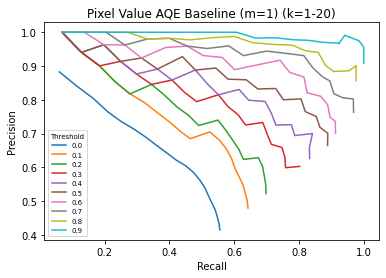

Threshold: 0.0 mAP: 0.62
Threshold: 0.1 mAP: 0.70
Threshold: 0.2 mAP: 0.74
Threshold: 0.3 mAP: 0.78
Threshold: 0.4 mAP: 0.82
Threshold: 0.5 mAP: 0.85
Threshold: 0.6 mAP: 0.88
Threshold: 0.7 mAP: 0.92
Threshold: 0.8 mAP: 0.95
Threshold: 0.9 mAP: 0.98
Overall mAP for k=1 to 20: 0.8239


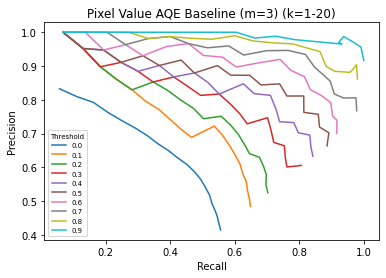

Threshold: 0.0 mAP: 0.62
Threshold: 0.1 mAP: 0.71
Threshold: 0.2 mAP: 0.75
Threshold: 0.3 mAP: 0.79
Threshold: 0.4 mAP: 0.82
Threshold: 0.5 mAP: 0.85
Threshold: 0.6 mAP: 0.89
Threshold: 0.7 mAP: 0.92
Threshold: 0.8 mAP: 0.95
Threshold: 0.9 mAP: 0.98
Overall mAP for k=1 to 20: 0.8276


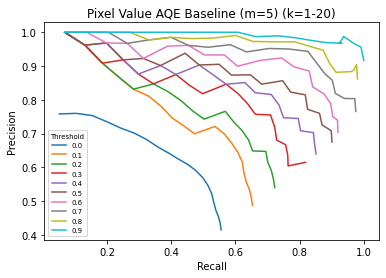

Threshold: 0.0 mAP: 0.61
Threshold: 0.1 mAP: 0.72
Threshold: 0.2 mAP: 0.75
Threshold: 0.3 mAP: 0.80
Threshold: 0.4 mAP: 0.83
Threshold: 0.5 mAP: 0.86
Threshold: 0.6 mAP: 0.89
Threshold: 0.7 mAP: 0.92
Threshold: 0.8 mAP: 0.95
Threshold: 0.9 mAP: 0.98
Overall mAP for k=1 to 20: 0.8309


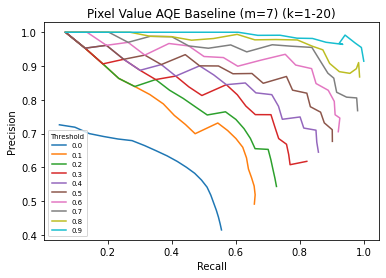

Threshold: 0.0 mAP: 0.59
Threshold: 0.1 mAP: 0.72
Threshold: 0.2 mAP: 0.76
Threshold: 0.3 mAP: 0.80
Threshold: 0.4 mAP: 0.83
Threshold: 0.5 mAP: 0.86
Threshold: 0.6 mAP: 0.89
Threshold: 0.7 mAP: 0.93
Threshold: 0.8 mAP: 0.96
Threshold: 0.9 mAP: 0.98
Overall mAP for k=1 to 20: 0.8317


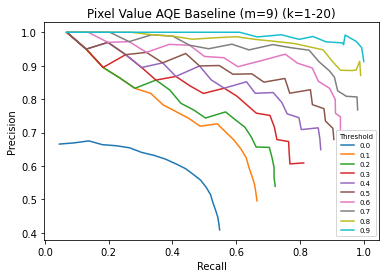

Threshold: 0.0 mAP: 0.58
Threshold: 0.1 mAP: 0.72
Threshold: 0.2 mAP: 0.75
Threshold: 0.3 mAP: 0.80
Threshold: 0.4 mAP: 0.83
Threshold: 0.5 mAP: 0.86
Threshold: 0.6 mAP: 0.90
Threshold: 0.7 mAP: 0.93
Threshold: 0.8 mAP: 0.96
Threshold: 0.9 mAP: 0.98
Overall mAP for k=1 to 20: 0.8300


In [18]:
averages_for_each_m = []
mAPs_for_each_m = []

for m in M_VALUES:
    averages, mAP = aqe_for_value_of_m(m)
    averages_for_each_m.append(averages)
    mAPs_for_each_m.append(mAP)


In [19]:
%store averages_for_each_m
%store mAPs_for_each_m
%store M_VALUES

Stored 'averages_for_each_m' (list)
Stored 'mAPs_for_each_m' (list)
Stored 'M_VALUES' (list)



Query: octopus


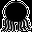

Original Results


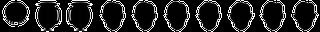

Precision: 0.10, Recall: 0.08
AQE Results with first 5 results
 


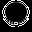

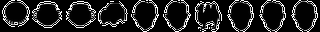

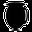

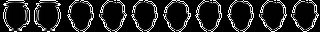

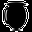

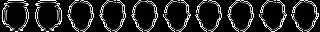

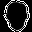

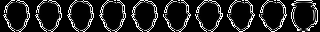

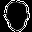

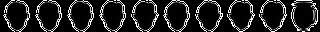

Final Results


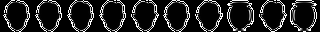

Precision: 0.00, Recall: 0.00

Query: hat


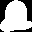

Original Results


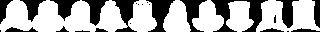

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


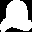

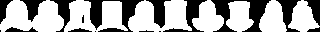

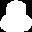

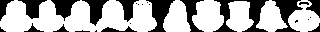

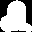

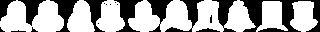

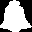

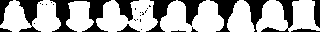

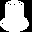

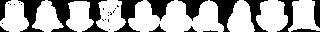

Final Results


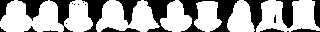

Precision: 0.90, Recall: 0.60

Query: Glas


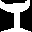

Original Results


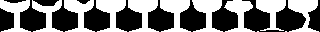

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


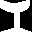

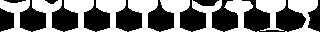

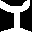

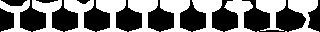

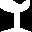

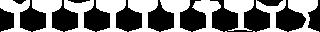

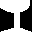

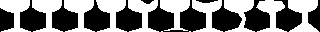

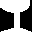

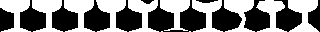

Final Results


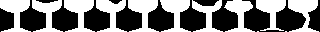

Precision: 1.00, Recall: 0.71

Query: spoon


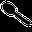

Original Results


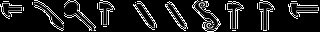

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


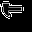

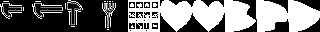

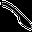

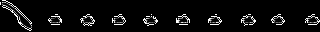

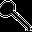

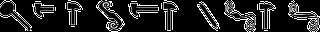

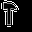

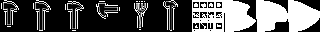

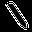

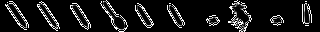

Final Results


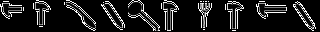

Precision: 0.20, Recall: 0.12

Query: device9


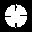

Original Results


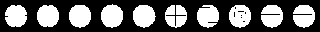

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


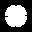

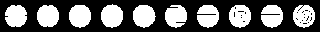

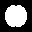

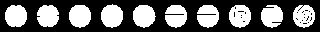

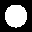

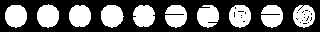

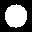

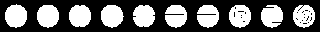

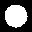

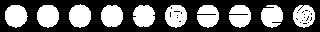

Final Results


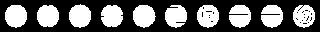

Precision: 1.00, Recall: 0.67

Query: cattle


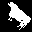

Original Results


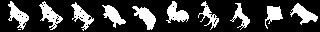

Precision: 0.40, Recall: 0.33
AQE Results with first 5 results
 


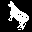

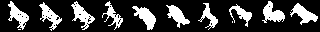

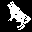

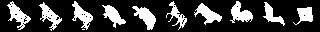

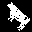

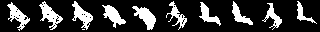

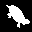

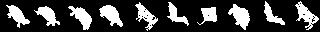

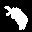

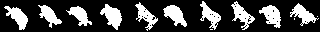

Final Results


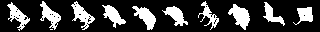

Precision: 0.30, Recall: 0.25

Query: fly


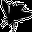

Original Results


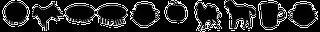

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


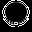

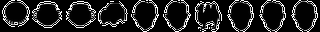

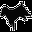

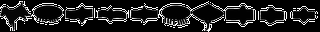

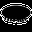

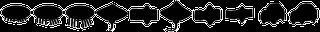

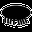

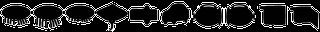

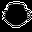

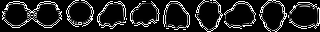

Final Results


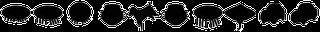

Precision: 0.00, Recall: 0.00

Query: horseshoe


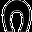

Original Results


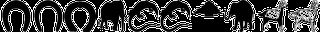

Precision: 0.30, Recall: 0.20
AQE Results with first 5 results
 


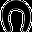

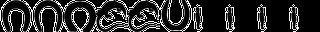

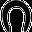

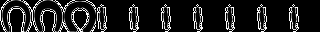

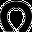

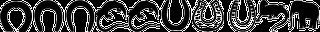

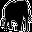

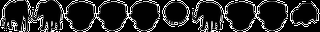

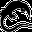

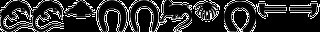

Final Results


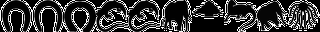

Precision: 0.30, Recall: 0.20

Query: cattle


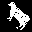

Original Results


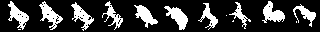

Precision: 0.30, Recall: 0.25
AQE Results with first 5 results
 


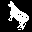

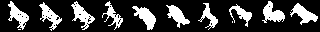

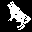

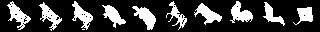

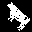

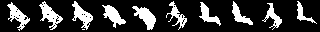

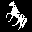

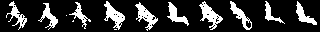

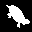

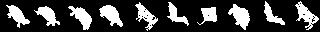

Final Results


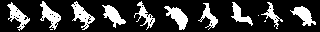

Precision: 0.30, Recall: 0.25

Query: car


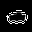

Original Results


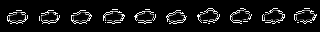

Precision: 1.00, Recall: 0.59
AQE Results with first 5 results
 


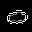

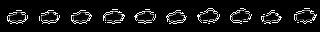

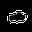

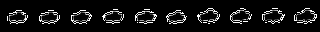

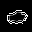

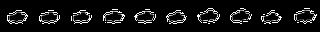

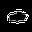

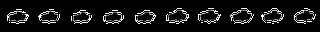

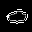

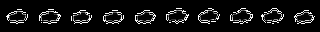

Final Results


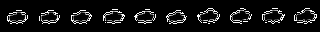

Precision: 1.00, Recall: 0.59

Query: Comma


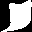

Original Results


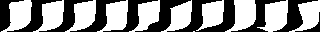

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


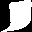

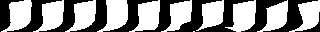

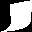

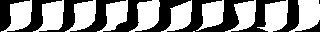

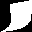

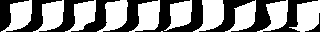

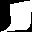

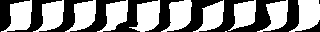

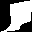

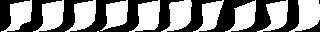

Final Results


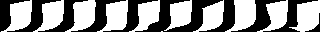

Precision: 1.00, Recall: 0.67

Query: device8


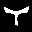

Original Results


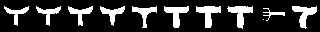

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


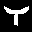

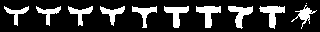

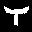

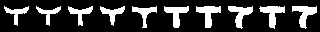

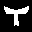

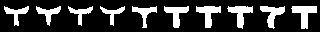

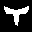

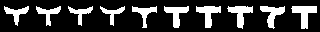

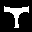

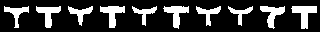

Final Results


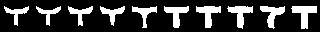

Precision: 1.00, Recall: 0.62

Query: crown


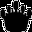

Original Results


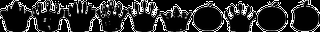

Precision: 0.70, Recall: 0.41
AQE Results with first 5 results
 


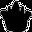

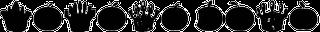

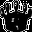

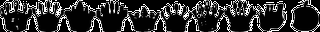

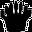

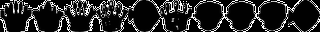

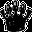

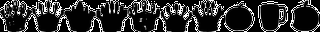

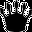

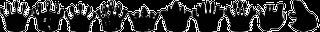

Final Results


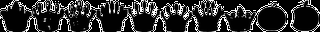

Precision: 0.80, Recall: 0.47

Query: device5


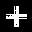

Original Results


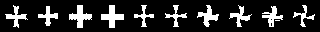

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


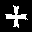

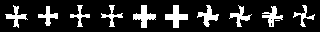

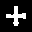

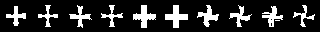

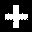

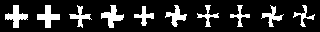

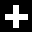

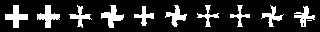

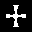

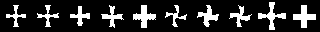

Final Results


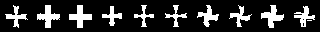

Precision: 1.00, Recall: 0.71

Query: HCircle


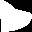

Original Results


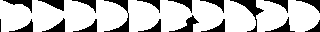

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


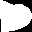

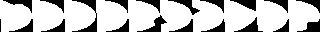

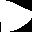

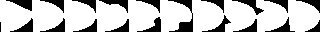

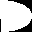

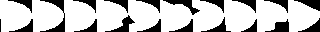

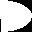

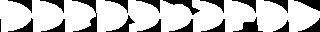

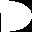

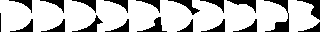

Final Results


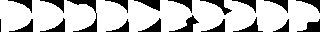

Precision: 1.00, Recall: 0.71

Query: brick


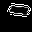

Original Results


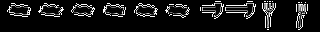

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


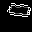

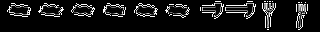

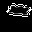

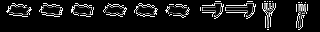

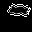

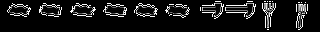

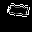

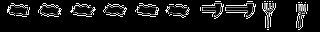

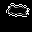

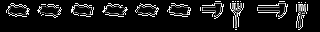

Final Results


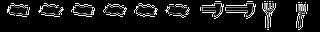

Precision: 0.60, Recall: 0.40

Query: device6


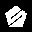

Original Results


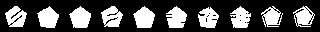

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


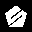

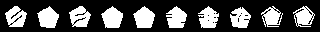

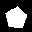

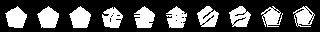

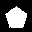

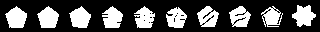

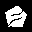

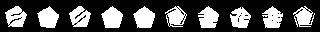

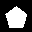

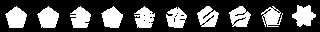

Final Results


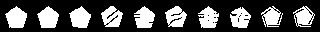

Precision: 1.00, Recall: 0.56

Query: flatfish


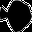

Original Results


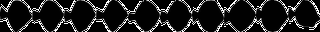

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


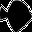

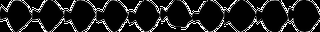

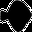

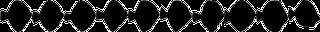

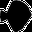

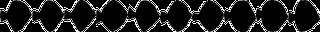

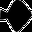

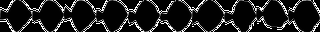

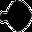

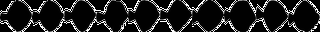

Final Results


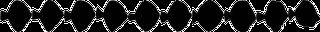

Precision: 1.00, Recall: 0.71

Query: chopper


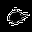

Original Results


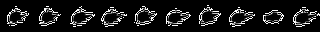

Precision: 0.90, Recall: 0.82
AQE Results with first 5 results
 


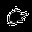

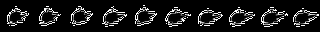

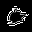

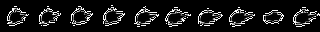

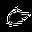

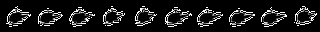

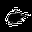

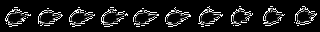

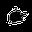

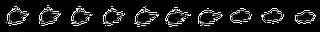

Final Results


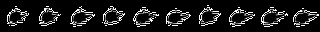

Precision: 1.00, Recall: 0.91

Query: shoe


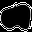

Original Results


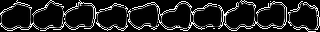

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


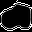

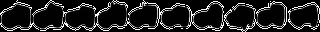

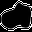

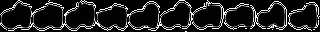

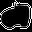

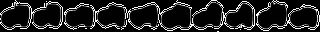

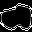

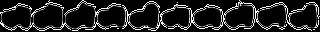

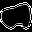

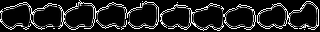

Final Results


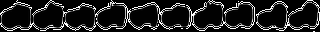

Precision: 1.00, Recall: 0.56

Query: cup


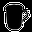

Original Results


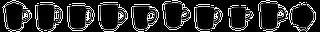

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


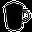

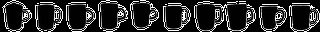

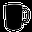

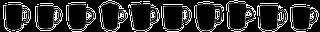

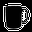

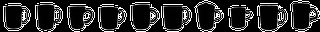

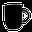

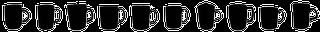

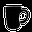

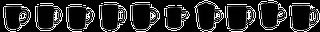

Final Results


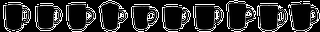

Precision: 1.00, Recall: 0.62

Query: HCircle


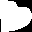

Original Results


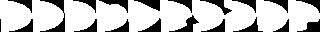

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


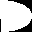

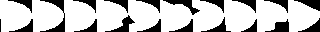

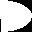

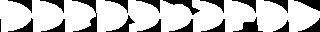

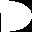

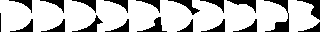

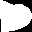

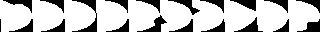

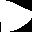

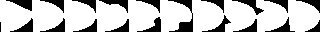

Final Results


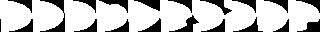

Precision: 1.00, Recall: 0.71

Query: device5


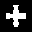

Original Results


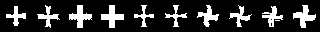

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


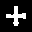

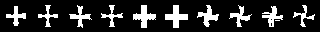

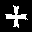

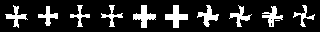

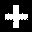

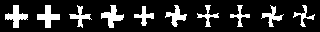

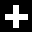

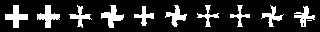

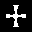

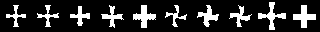

Final Results


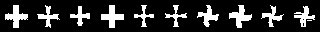

Precision: 1.00, Recall: 0.71

Query: stef


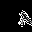

Original Results


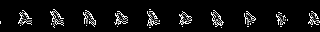

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


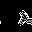

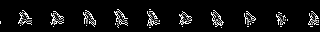

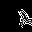

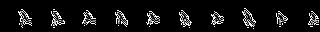

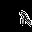

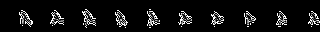

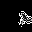

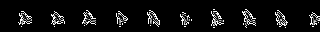

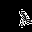

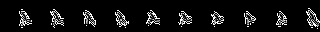

Final Results


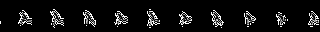

Precision: 1.00, Recall: 0.56

Query: lmfish


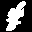

Original Results


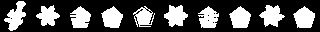

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


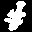

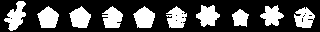

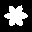

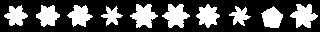

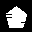

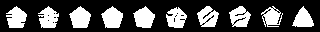

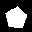

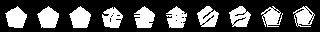

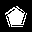

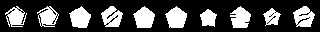

Final Results


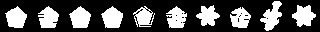

Precision: 0.10, Recall: 0.06

Query: bell


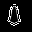

Original Results


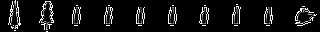

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


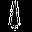

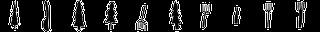

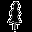

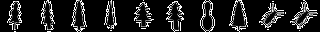

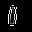

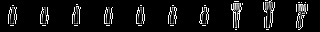

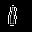

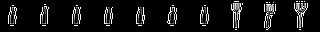

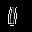

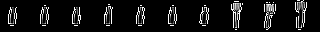

Final Results


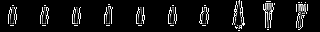

Precision: 0.00, Recall: 0.00

Query: cattle


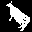

Original Results


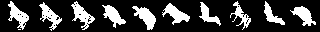

Precision: 0.40, Recall: 0.33
AQE Results with first 5 results
 


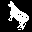

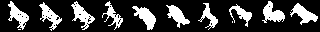

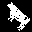

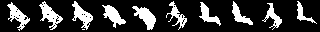

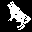

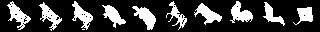

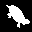

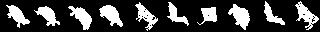

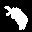

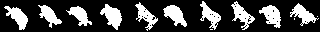

Final Results


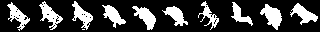

Precision: 0.40, Recall: 0.33

Query: device3


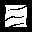

Original Results


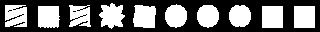

Precision: 0.60, Recall: 0.43
AQE Results with first 5 results
 


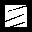

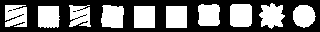

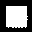

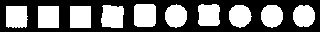

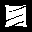

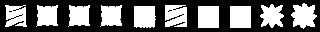

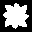

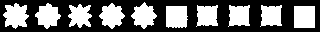

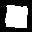

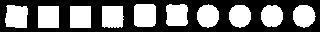

Final Results


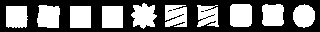

Precision: 0.80, Recall: 0.57

Query: guitar


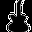

Original Results


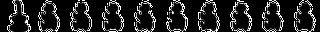

Precision: 0.10, Recall: 0.07
AQE Results with first 5 results
 


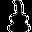

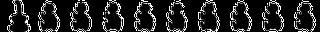

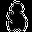

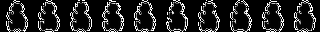

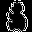

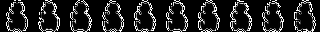

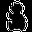

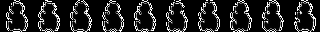

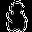

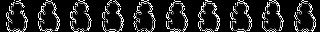

Final Results


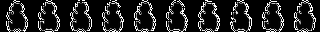

Precision: 0.00, Recall: 0.00

Query: horse


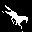

Original Results


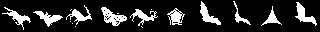

Precision: 0.10, Recall: 0.07
AQE Results with first 5 results
 


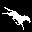

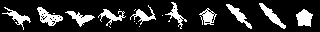

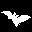

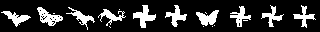

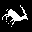

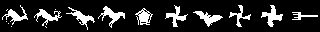

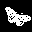

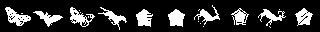

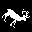

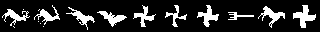

Final Results


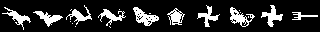

Precision: 0.10, Recall: 0.07

Query: fountain


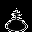

Original Results


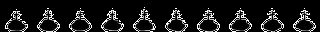

Precision: 1.00, Recall: 0.59
AQE Results with first 5 results
 


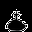

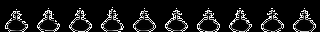

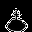

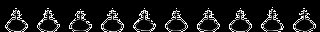

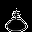

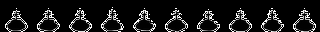

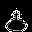

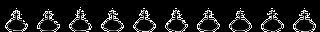

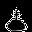

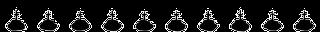

Final Results


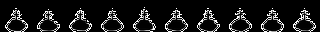

Precision: 1.00, Recall: 0.59

Query: Misk


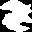

Original Results


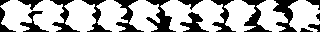

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


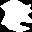

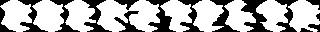

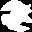

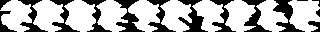

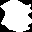

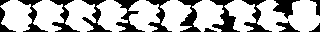

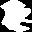

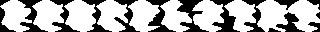

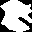

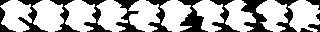

Final Results


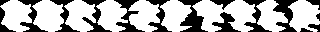

Precision: 1.00, Recall: 0.67

Query: flatfish


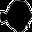

Original Results


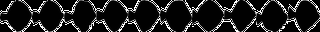

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


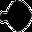

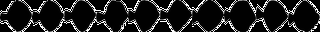

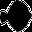

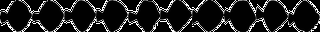

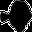

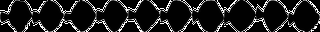

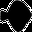

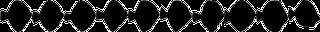

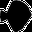

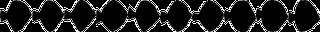

Final Results


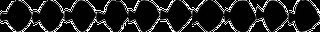

Precision: 1.00, Recall: 0.71

Query: key


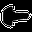

Original Results


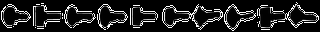

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


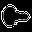

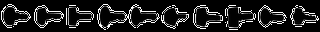

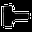

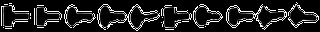

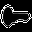

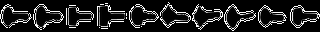

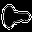

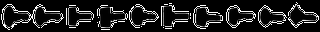

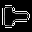

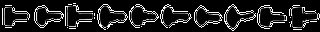

Final Results


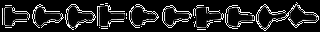

Precision: 1.00, Recall: 0.71

Query: flatfish


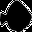

Original Results


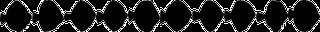

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


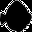

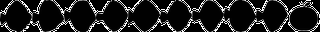

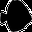

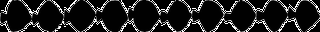

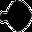

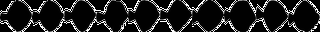

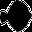

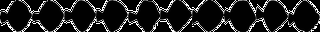

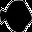

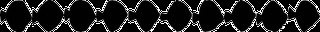

Final Results


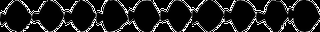

Precision: 1.00, Recall: 0.71

Query: spring


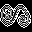

Original Results


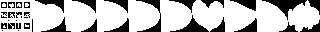

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


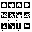

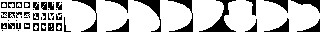

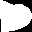

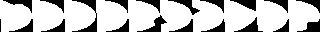

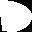

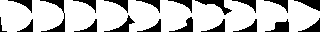

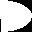

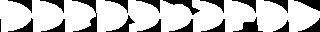

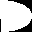

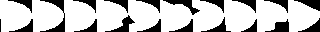

Final Results


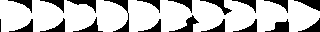

Precision: 0.00, Recall: 0.00

Query: pencil


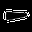

Original Results


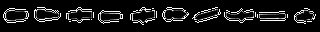

Precision: 0.60, Recall: 0.38
AQE Results with first 5 results
 


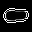

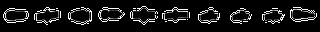

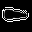

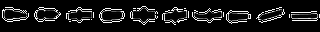

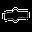

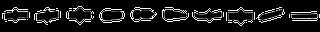

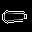

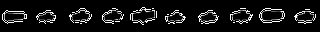

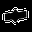

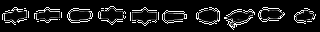

Final Results


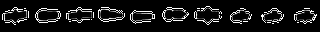

Precision: 0.40, Recall: 0.25

Query: children


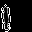

Original Results


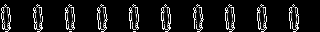

Precision: 1.00, Recall: 0.53
AQE Results with first 5 results
 


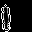

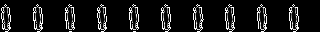

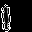

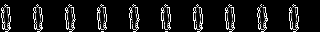

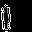

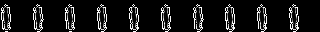

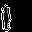

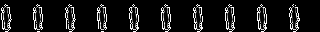

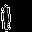

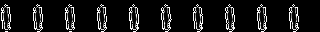

Final Results


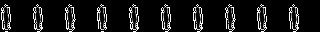

Precision: 1.00, Recall: 0.53

Query: octopus


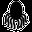

Original Results


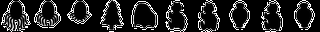

Precision: 0.30, Recall: 0.23
AQE Results with first 5 results
 


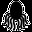

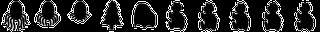

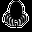

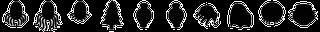

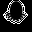

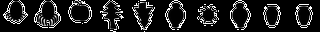

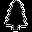

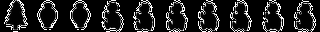

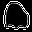

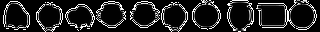

Final Results


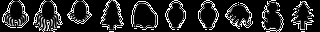

Precision: 0.30, Recall: 0.23

Query: watch


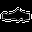

Original Results


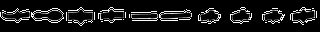

Precision: 0.40, Recall: 0.29
AQE Results with first 5 results
 


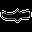

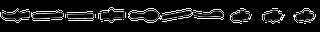

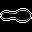

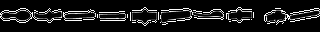

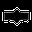

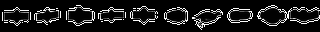

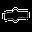

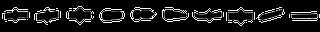

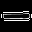

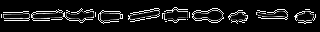

Final Results


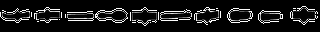

Precision: 0.50, Recall: 0.36

Query: fly


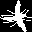

Original Results


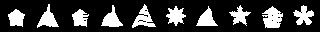

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


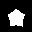

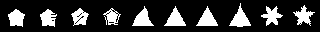

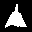

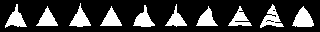

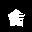

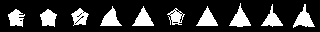

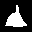

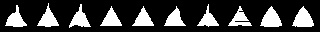

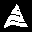

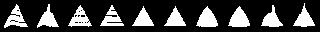

Final Results


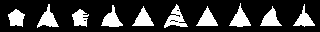

Precision: 0.00, Recall: 0.00

Query: butterfly


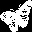

Original Results


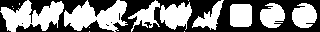

Precision: 0.10, Recall: 0.07
AQE Results with first 5 results
 


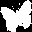

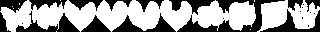

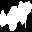

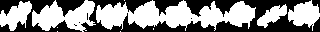

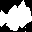

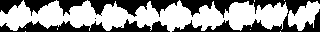

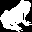

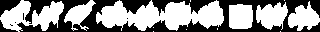

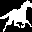

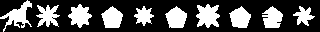

Final Results


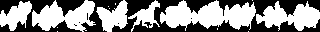

Precision: 0.10, Recall: 0.07

Query: fish


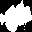

Original Results


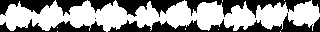

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


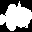

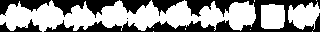

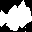

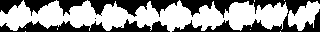

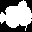

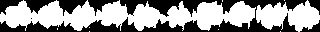

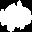

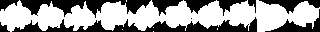

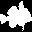

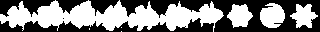

Final Results


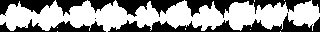

Precision: 1.00, Recall: 0.67

Query: key


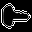

Original Results


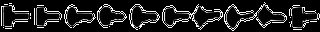

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


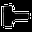

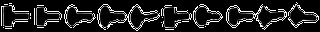

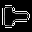

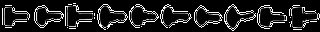

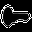

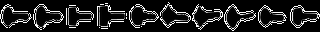

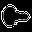

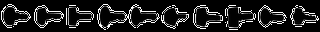

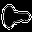

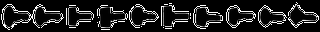

Final Results


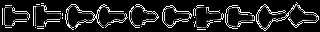

Precision: 1.00, Recall: 0.71

Query: octopus


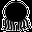

Original Results


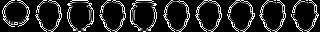

Precision: 0.10, Recall: 0.08
AQE Results with first 5 results
 


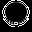

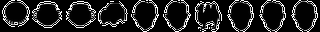

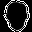

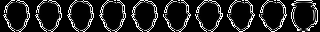

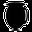

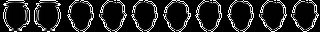

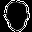

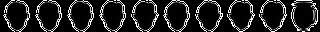

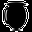

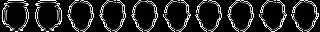

Final Results


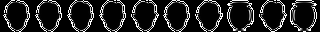

Precision: 0.00, Recall: 0.00

Query: hat


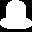

Original Results


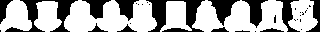

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


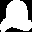

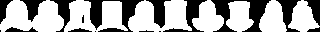

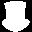

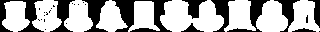

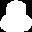

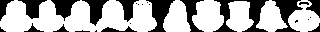

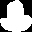

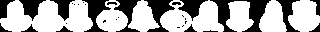

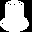

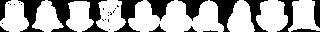

Final Results


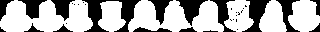

Precision: 0.90, Recall: 0.60

Query: horse


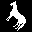

Original Results


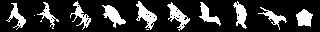

Precision: 0.40, Recall: 0.27
AQE Results with first 5 results
 


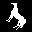

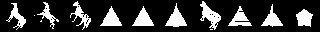

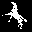

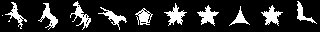

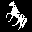

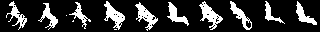

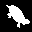

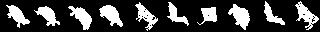

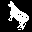

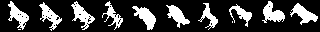

Final Results


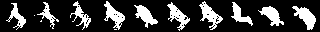

Precision: 0.30, Recall: 0.20

Query: bottle


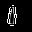

Original Results


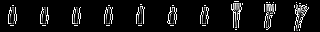

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


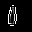

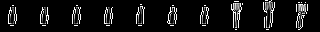

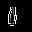

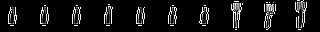

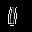

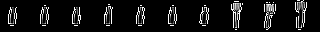

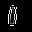

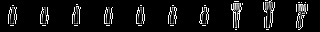

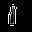

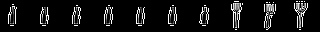

Final Results


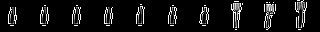

Precision: 0.70, Recall: 0.50

Query: Glas


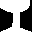

Original Results


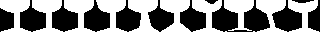

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


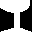

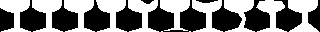

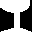

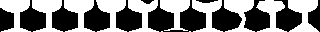

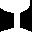

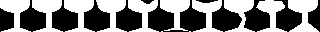

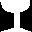

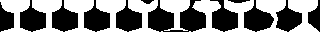

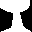

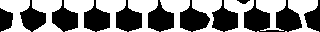

Final Results


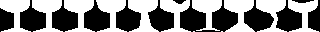

Precision: 1.00, Recall: 0.71

Query: Glas


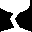

Original Results


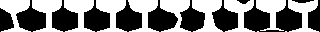

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


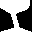

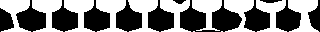

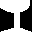

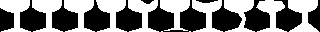

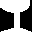

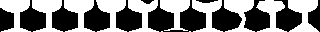

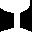

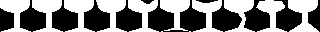

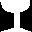

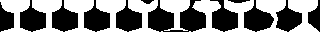

Final Results


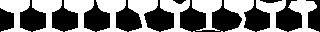

Precision: 1.00, Recall: 0.71

Query: bell


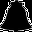

Original Results


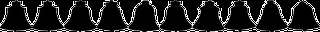

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


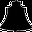

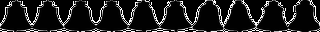

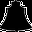

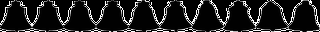

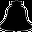

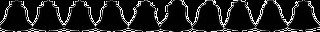

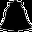

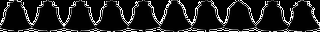

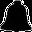

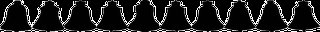

Final Results


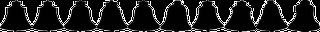

Precision: 1.00, Recall: 0.67

Query: hat


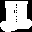

Original Results


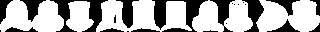

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


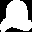

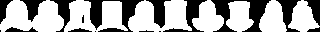

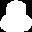

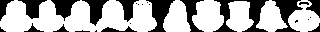

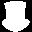

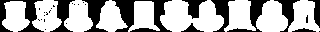

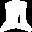

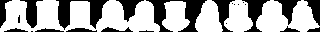

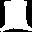

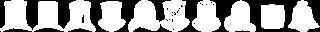

Final Results


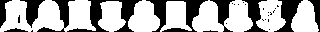

Precision: 1.00, Recall: 0.67

Query: cellular_phone


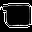

Original Results


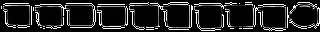

Precision: 0.90, Recall: 0.69
AQE Results with first 5 results
 


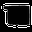

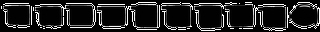

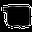

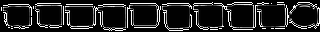

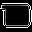

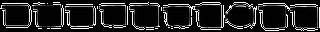

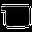

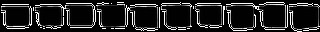

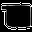

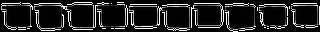

Final Results


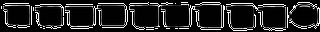

Precision: 0.90, Recall: 0.69

Query: HCircle


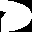

Original Results


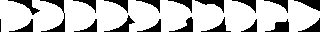

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


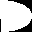

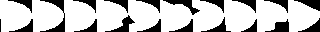

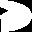

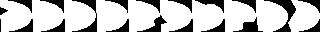

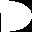

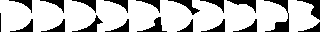

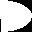

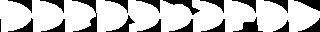

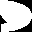

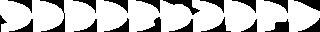

Final Results


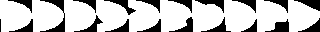

Precision: 1.00, Recall: 0.71

Query: HCircle


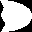

Original Results


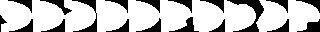

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


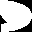

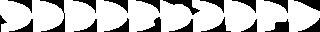

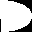

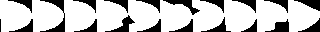

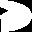

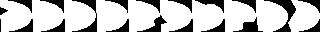

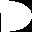

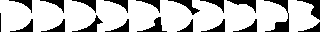

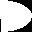

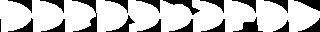

Final Results


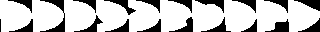

Precision: 1.00, Recall: 0.71

Query: butterfly


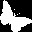

Original Results


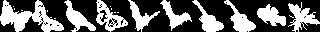

Precision: 0.30, Recall: 0.21
AQE Results with first 5 results
 


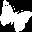

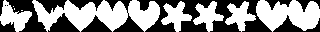

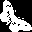

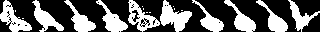

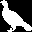

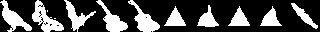

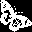

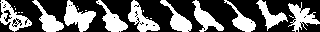

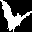

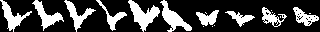

Final Results


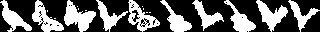

Precision: 0.30, Recall: 0.21

Query: key


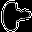

Original Results


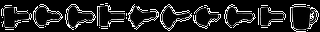

Precision: 0.90, Recall: 0.64
AQE Results with first 5 results
 


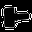

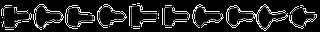

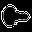

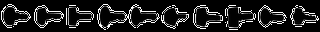

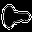

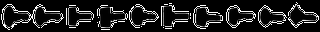

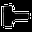

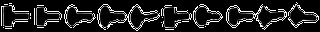

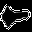

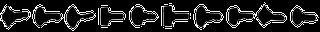

Final Results


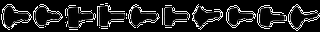

Precision: 1.00, Recall: 0.71

Query: pocket


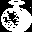

Original Results


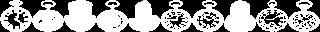

Precision: 0.70, Recall: 0.41
AQE Results with first 5 results
 


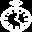

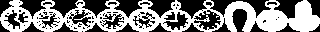

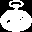

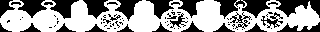

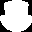

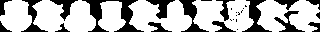

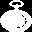

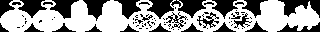

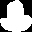

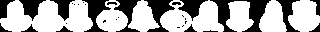

Final Results


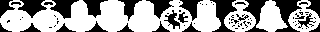

Precision: 0.50, Recall: 0.29

Query: device0


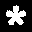

Original Results


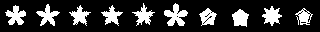

Precision: 0.60, Recall: 0.43
AQE Results with first 5 results
 


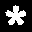

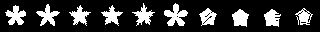

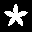

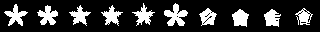

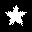

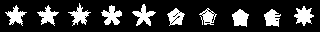

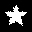

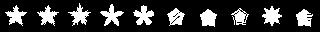

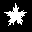

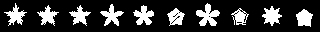

Final Results


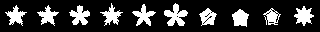

Precision: 0.60, Recall: 0.43

Query: horseshoe


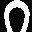

Original Results


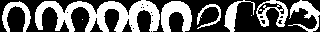

Precision: 0.70, Recall: 0.47
AQE Results with first 5 results
 


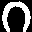

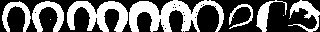

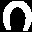

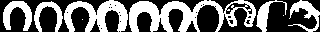

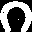

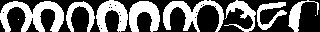

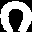

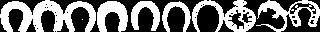

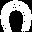

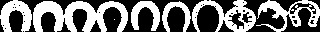

Final Results


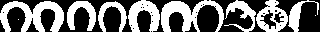

Precision: 0.70, Recall: 0.47

Query: ray


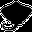

Original Results


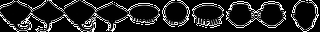

Precision: 0.40, Recall: 0.36
AQE Results with first 5 results
 


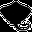

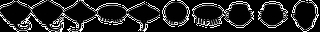

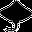

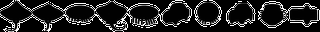

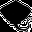

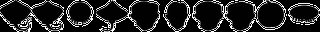

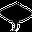

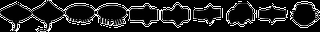

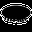

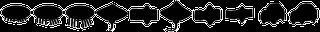

Final Results


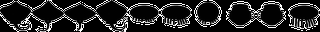

Precision: 0.40, Recall: 0.36

Query: octopus


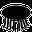

Original Results


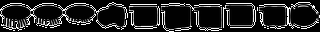

Precision: 0.30, Recall: 0.23
AQE Results with first 5 results
 


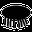

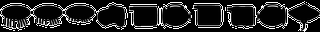

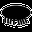

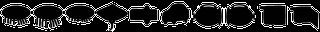

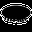

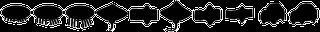

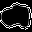

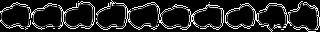

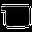

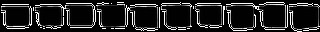

Final Results


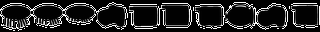

Precision: 0.30, Recall: 0.23

Query: device9


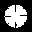

Original Results


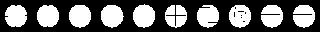

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


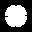

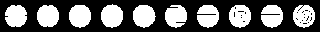

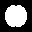

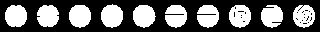

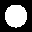

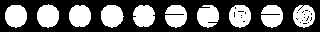

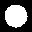

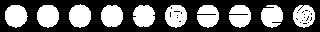

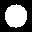

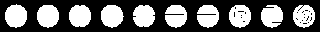

Final Results


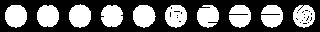

Precision: 1.00, Recall: 0.67

Query: cellular_phone


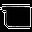

Original Results


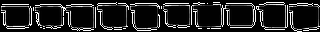

Precision: 1.00, Recall: 0.77
AQE Results with first 5 results
 


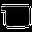

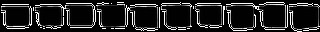

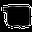

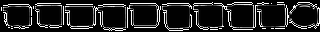

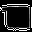

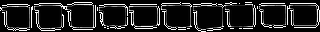

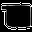

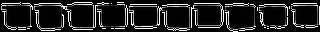

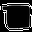

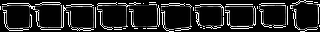

Final Results


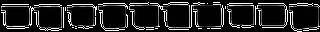

Precision: 1.00, Recall: 0.77

Query: ray


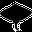

Original Results


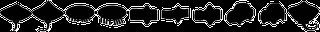

Precision: 0.30, Recall: 0.27
AQE Results with first 5 results
 


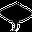

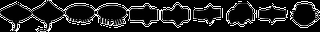

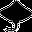

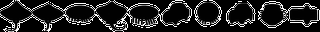

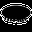

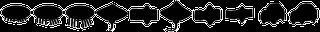

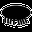

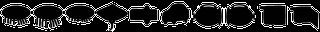

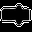

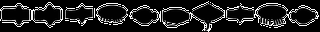

Final Results


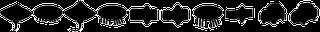

Precision: 0.20, Recall: 0.18

Query: fork


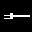

Original Results


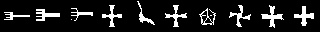

Precision: 0.30, Recall: 0.23
AQE Results with first 5 results
 


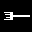

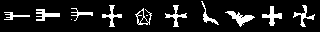

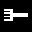

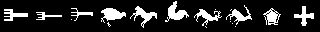

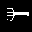

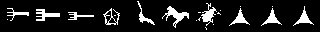

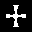

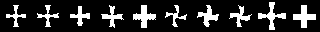

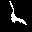

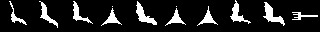

Final Results


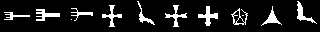

Precision: 0.30, Recall: 0.23

Query: bird


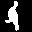

Original Results


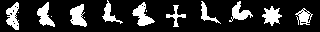

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


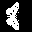

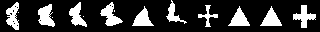

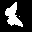

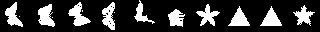

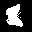

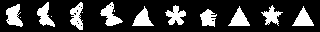

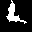

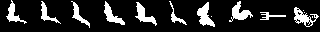

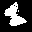

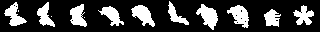

Final Results


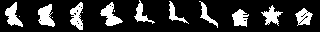

Precision: 0.00, Recall: 0.00

Query: device9


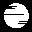

Original Results


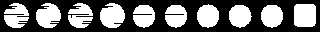

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


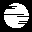

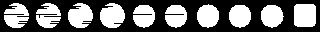

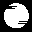

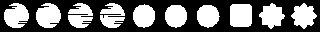

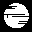

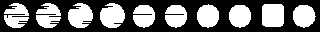

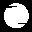

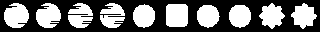

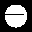

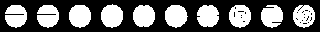

Final Results


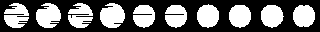

Precision: 1.00, Recall: 0.67

Query: truck


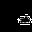

Original Results


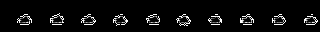

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


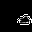

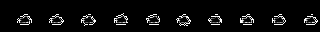

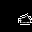

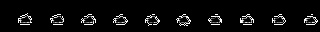

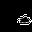

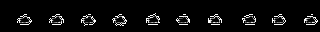

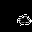

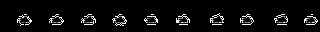

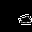

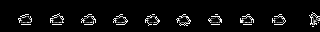

Final Results


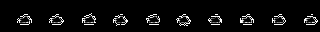

Precision: 1.00, Recall: 0.67

Query: bell


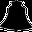

Original Results


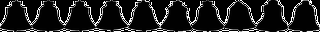

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


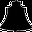

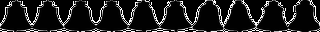

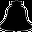

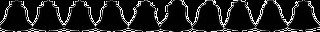

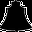

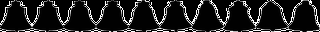

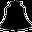

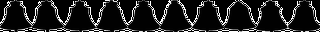

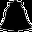

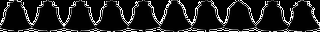

Final Results


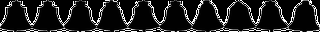

Precision: 1.00, Recall: 0.67

Query: elephant


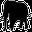

Original Results


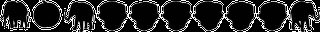

Precision: 0.30, Recall: 0.18
AQE Results with first 5 results
 


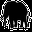

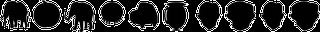

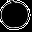

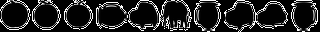

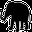

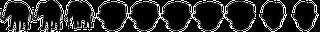

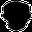

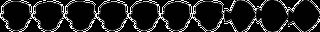

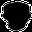

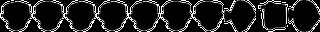

Final Results


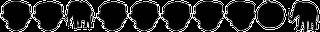

Precision: 0.20, Recall: 0.12

Query: chopper


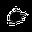

Original Results


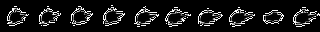

Precision: 0.90, Recall: 0.82
AQE Results with first 5 results
 


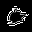

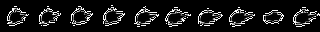

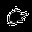

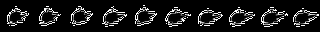

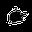

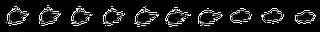

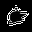

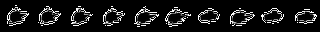

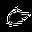

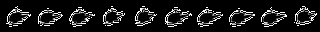

Final Results


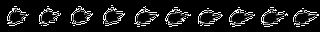

Precision: 1.00, Recall: 0.91

Query: bird


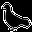

Original Results


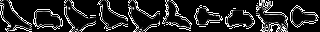

Precision: 0.40, Recall: 0.24
AQE Results with first 5 results
 


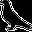

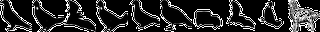

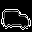

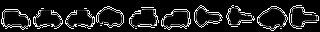

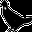

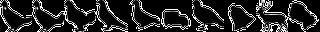

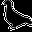

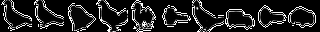

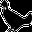

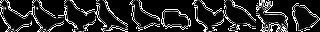

Final Results


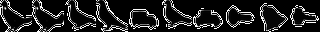

Precision: 0.50, Recall: 0.29

Query: butterfly


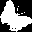

Original Results


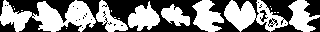

Precision: 0.30, Recall: 0.21
AQE Results with first 5 results
 


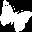

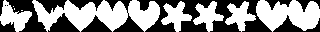

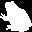

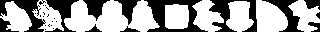

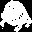

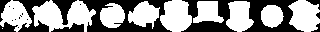

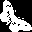

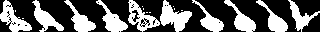

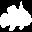

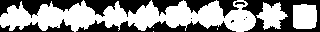

Final Results


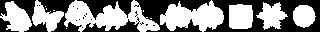

Precision: 0.20, Recall: 0.14

Query: bell


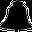

Original Results


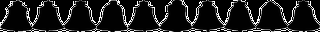

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


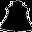

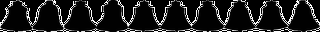

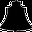

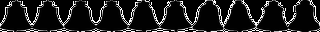

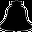

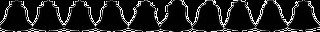

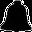

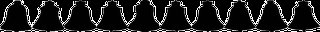

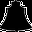

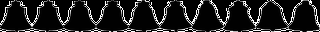

Final Results


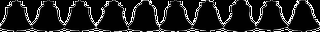

Precision: 1.00, Recall: 0.67

Query: face


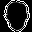

Original Results


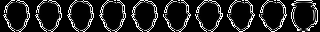

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


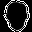

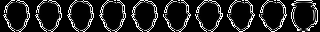

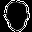

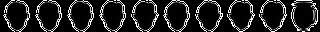

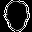

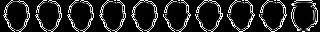

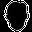

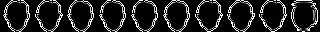

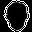

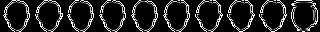

Final Results


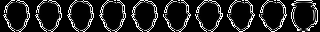

Precision: 0.90, Recall: 0.56

Query: hammer


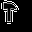

Original Results


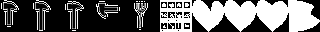

Precision: 0.40, Recall: 0.25
AQE Results with first 5 results
 


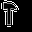

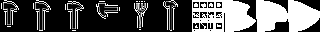

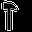

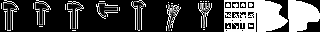

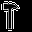

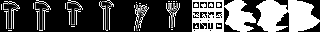

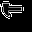

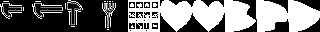

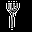

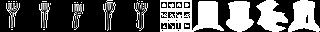

Final Results


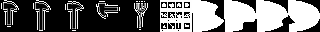

Precision: 0.40, Recall: 0.25

Query: guitar


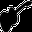

Original Results


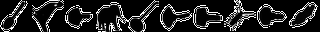

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


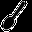

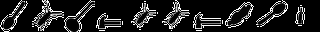

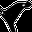

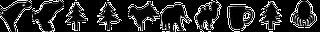

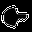

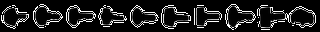

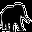

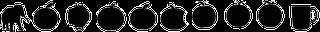

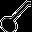

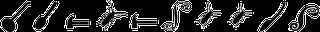

Final Results


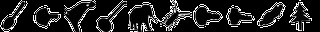

Precision: 0.00, Recall: 0.00

Query: truck


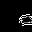

Original Results


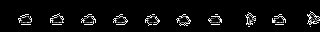

Precision: 0.80, Recall: 0.53
AQE Results with first 5 results
 


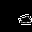

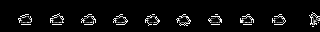

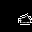

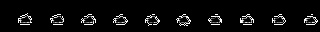

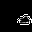

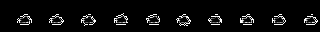

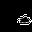

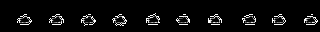

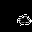

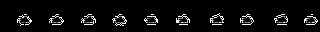

Final Results


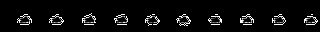

Precision: 1.00, Recall: 0.67

Query: Glas


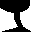

Original Results


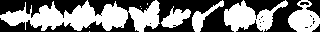

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


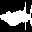

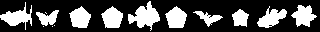

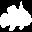

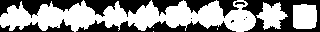

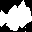

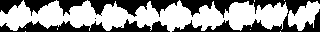

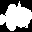

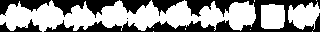

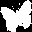

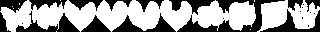

Final Results


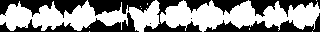

Precision: 0.00, Recall: 0.00

Query: guitar


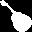

Original Results


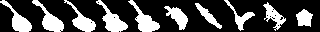

Precision: 0.50, Recall: 0.33
AQE Results with first 5 results
 


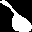

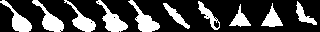

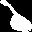

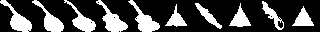

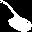

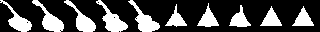

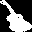

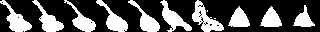

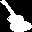

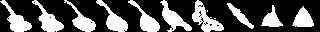

Final Results


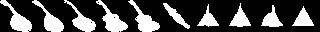

Precision: 0.50, Recall: 0.33

Query: bottle


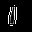

Original Results


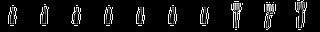

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


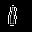

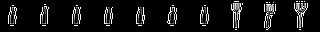

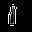

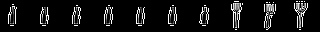

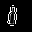

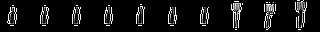

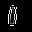

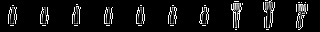

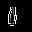

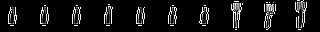

Final Results


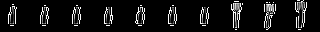

Precision: 0.70, Recall: 0.50

Query: chopper


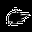

Original Results


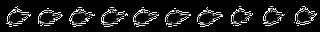

Precision: 1.00, Recall: 0.91
AQE Results with first 5 results
 


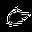

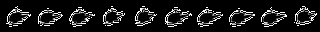

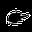

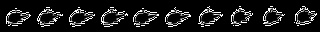

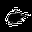

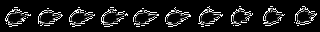

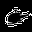

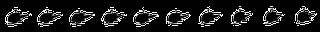

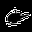

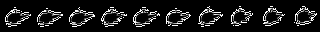

Final Results


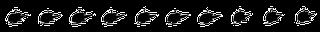

Precision: 1.00, Recall: 0.91

Query: fork


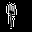

Original Results


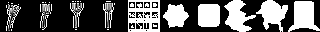

Precision: 0.40, Recall: 0.31
AQE Results with first 5 results
 


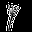

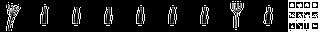

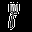

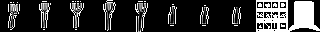

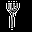

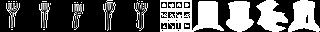

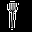

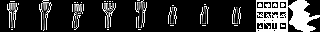

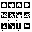

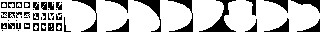

Final Results


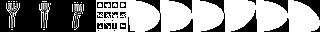

Precision: 0.30, Recall: 0.23

Query: device3


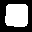

Original Results


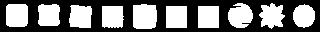

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


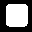

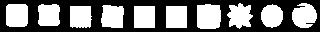

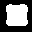

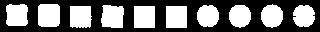

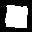

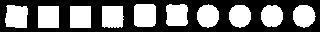

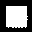

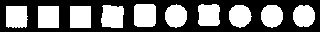

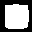

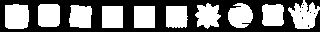

Final Results


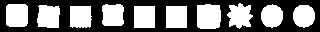

Precision: 0.70, Recall: 0.50

Query: device5


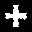

Original Results


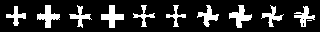

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


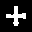

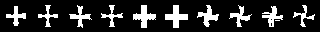

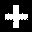

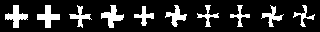

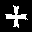

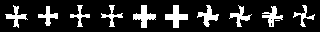

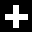

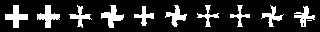

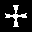

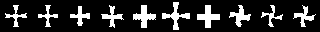

Final Results


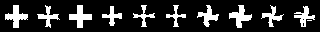

Precision: 1.00, Recall: 0.71

Query: device4


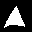

Original Results


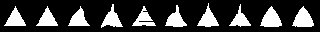

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


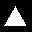

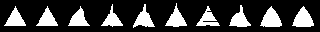

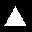

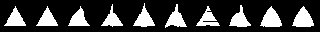

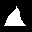

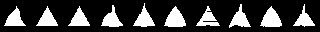

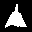

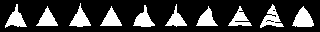

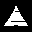

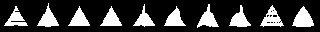

Final Results


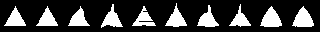

Precision: 1.00, Recall: 0.62

Query: elephant


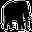

Original Results


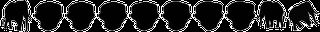

Precision: 0.30, Recall: 0.18
AQE Results with first 5 results
 


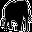

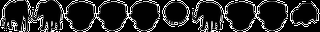

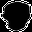

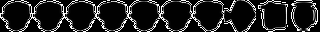

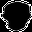

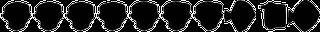

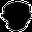

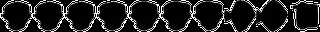

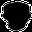

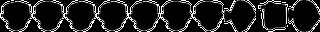

Final Results


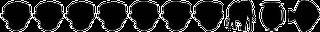

Precision: 0.10, Recall: 0.06

Query: key


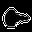

Original Results


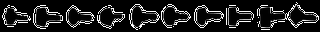

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


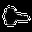

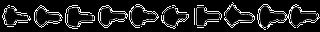

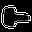

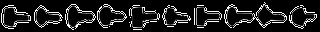

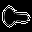

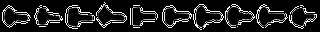

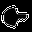

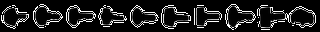

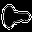

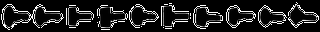

Final Results


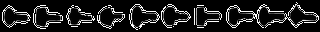

Precision: 1.00, Recall: 0.71

Query: lizzard


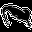

Original Results


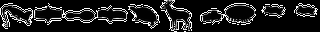

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


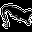

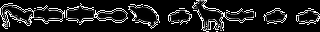

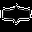

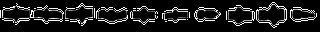

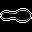

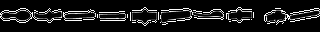

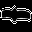

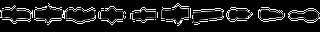

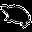

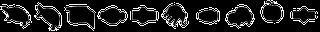

Final Results


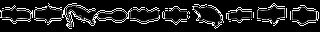

Precision: 0.10, Recall: 0.06

Query: device0


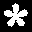

Original Results


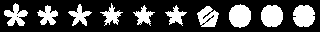

Precision: 0.60, Recall: 0.43
AQE Results with first 5 results
 


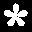

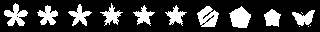

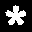

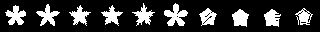

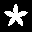

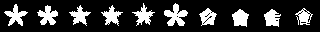

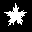

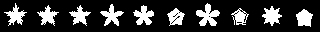

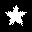

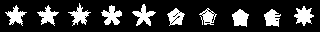

Final Results


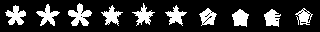

Precision: 0.60, Recall: 0.43

Query: horseshoe


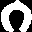

Original Results


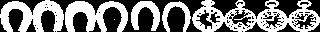

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


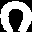

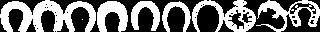

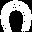

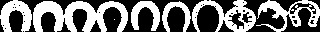

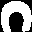

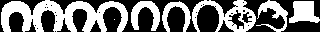

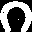

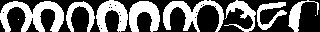

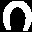

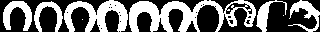

Final Results


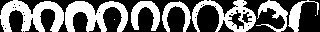

Precision: 0.70, Recall: 0.47

Query: HCircle


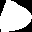

Original Results


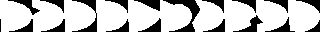

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


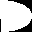

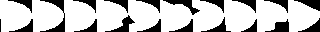

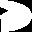

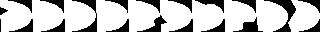

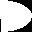

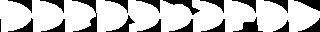

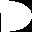

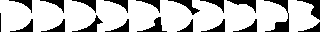

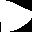

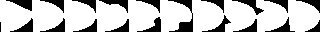

Final Results


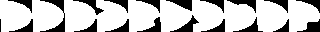

Precision: 1.00, Recall: 0.71

Query: fountain


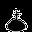

Original Results


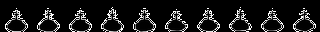

Precision: 1.00, Recall: 0.59
AQE Results with first 5 results
 


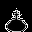

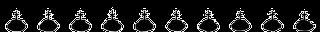

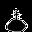

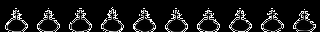

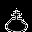

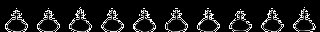

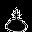

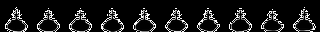

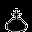

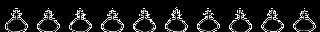

Final Results


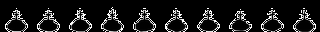

Precision: 1.00, Recall: 0.59

Query: device4


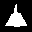

Original Results


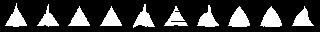

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


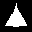

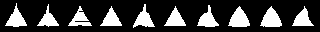

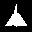

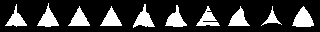

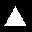

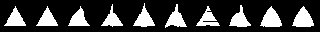

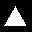

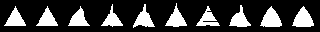

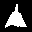

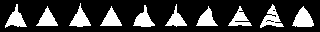

Final Results


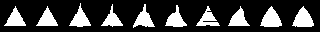

Precision: 1.00, Recall: 0.62

Query: chopper


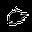

Original Results


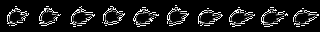

Precision: 1.00, Recall: 0.91
AQE Results with first 5 results
 


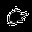

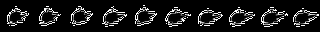

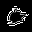

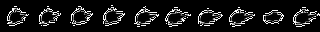

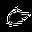

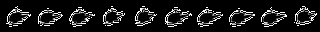

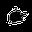

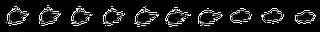

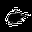

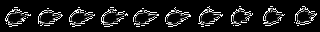

Final Results


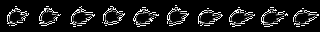

Precision: 1.00, Recall: 0.91

Query: horse


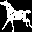

Original Results


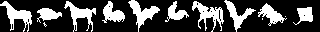

Precision: 0.30, Recall: 0.20
AQE Results with first 5 results
 


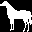

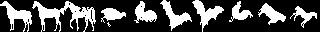

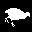

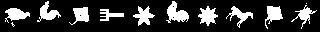

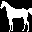

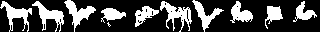

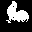

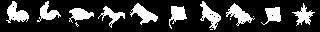

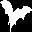

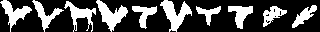

Final Results


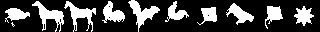

Precision: 0.20, Recall: 0.13

Query: device8


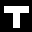

Original Results


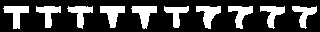

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


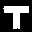

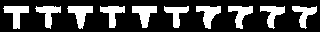

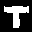

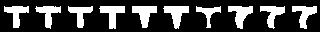

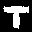

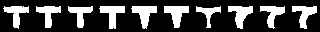

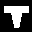

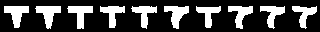

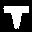

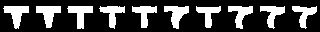

Final Results


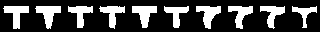

Precision: 1.00, Recall: 0.62

Query: cellular_phone


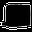

Original Results


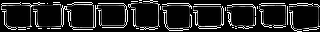

Precision: 1.00, Recall: 0.77
AQE Results with first 5 results
 


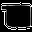

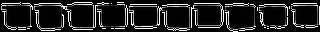

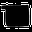

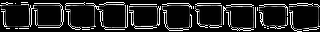

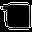

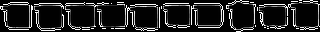

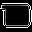

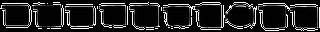

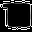

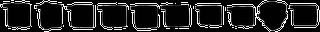

Final Results


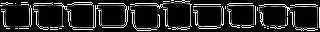

Precision: 1.00, Recall: 0.77

Query: cellular_phone


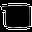

Original Results


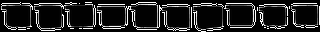

Precision: 1.00, Recall: 0.77
AQE Results with first 5 results
 


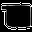

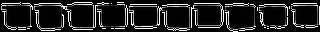

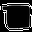

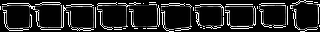

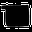

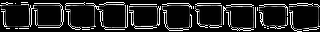

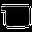

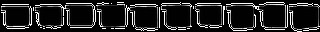

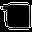

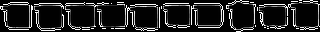

Final Results


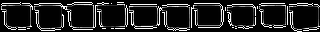

Precision: 1.00, Recall: 0.77

Query: Comma


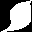

Original Results


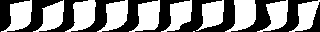

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


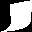

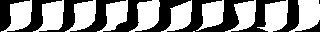

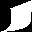

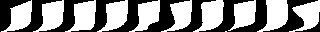

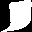

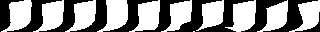

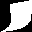

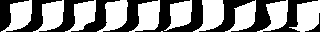

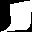

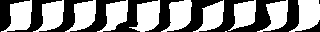

Final Results


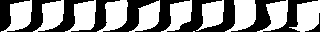

Precision: 1.00, Recall: 0.67

Query: device3


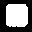

Original Results


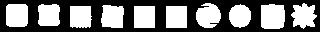

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


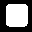

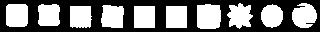

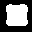

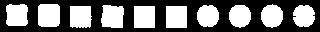

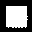

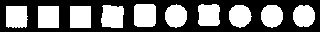

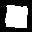

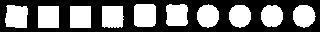

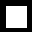

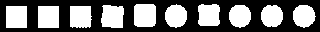

Final Results


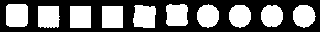

Precision: 0.60, Recall: 0.43

Query: cattle


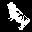

Original Results


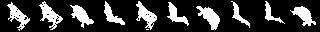

Precision: 0.30, Recall: 0.25
AQE Results with first 5 results
 


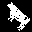

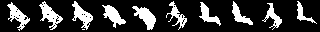

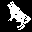

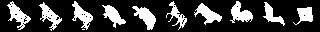

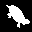

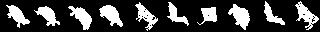

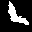

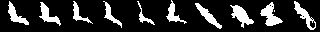

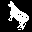

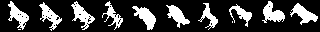

Final Results


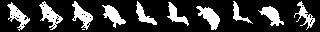

Precision: 0.30, Recall: 0.25

Query: face


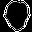

Original Results


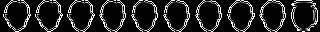

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


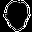

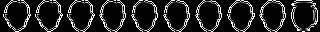

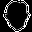

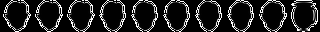

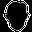

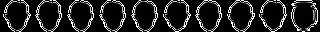

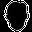

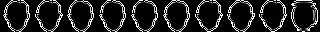

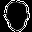

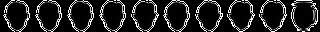

Final Results


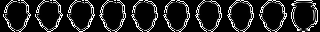

Precision: 0.90, Recall: 0.56

Query: fork


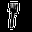

Original Results


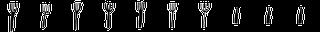

Precision: 0.70, Recall: 0.54
AQE Results with first 5 results
 


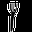

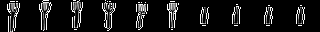

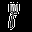

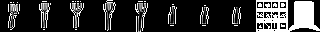

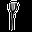

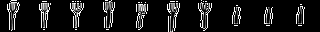

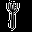

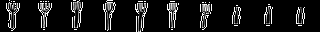

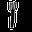

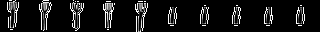

Final Results


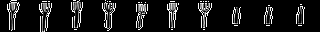

Precision: 0.70, Recall: 0.54

Query: rat


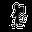

Original Results


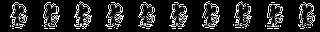

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


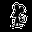

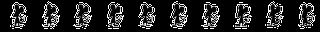

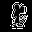

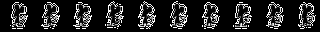

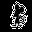

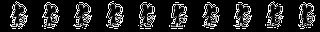

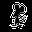

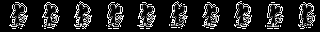

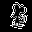

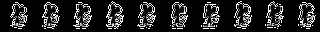

Final Results


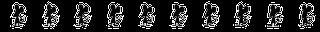

Precision: 1.00, Recall: 0.56

Query: chopper


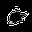

Original Results


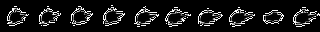

Precision: 0.90, Recall: 0.82
AQE Results with first 5 results
 


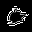

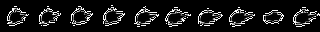

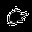

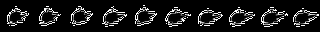

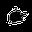

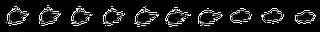

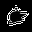

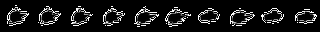

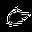

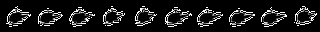

Final Results


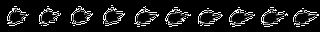

Precision: 1.00, Recall: 0.91

Query: lizzard


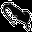

Original Results


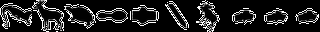

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


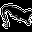

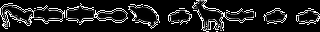

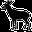

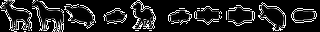

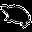

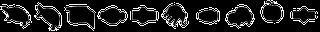

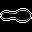

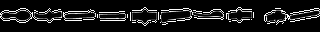

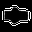

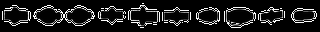

Final Results


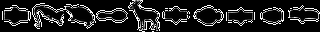

Precision: 0.10, Recall: 0.06

Query: device5


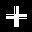

Original Results


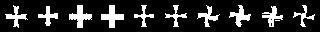

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


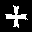

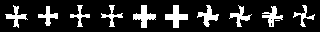

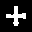

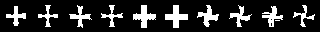

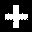

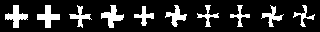

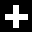

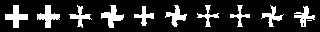

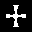

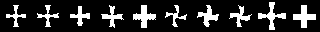

Final Results


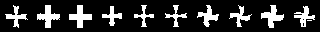

Precision: 1.00, Recall: 0.71

Query: pocket


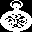

Original Results


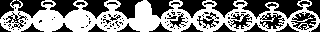

Precision: 0.90, Recall: 0.53
AQE Results with first 5 results
 


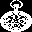

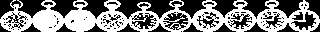

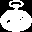

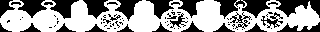

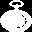

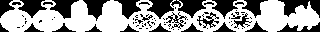

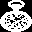

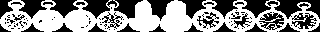

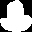

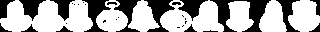

Final Results


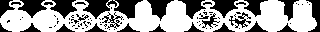

Precision: 0.60, Recall: 0.35

Query: ray


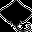

Original Results


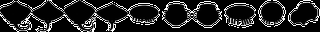

Precision: 0.40, Recall: 0.36
AQE Results with first 5 results
 


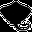

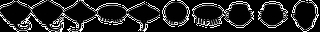

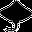

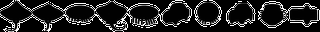

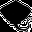

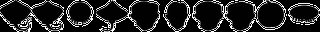

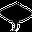

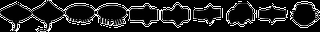

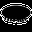

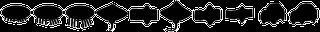

Final Results


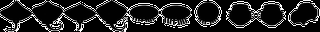

Precision: 0.40, Recall: 0.36

Query: fork


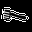

Original Results


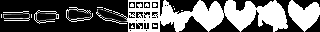

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


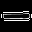

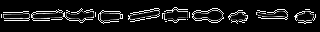

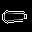

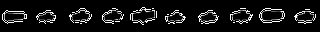

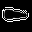

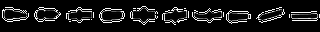

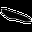

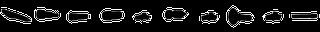

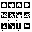

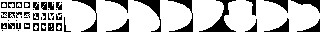

Final Results


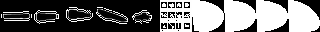

Precision: 0.00, Recall: 0.00

Query: device4


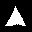

Original Results


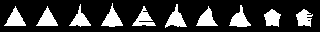

Precision: 0.80, Recall: 0.50
AQE Results with first 5 results
 


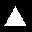

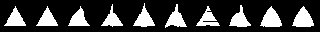

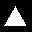

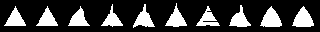

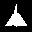

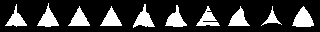

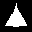

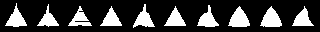

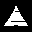

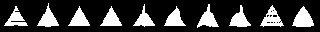

Final Results


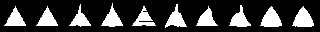

Precision: 1.00, Recall: 0.62

Query: Misk


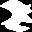

Original Results


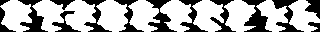

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


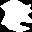

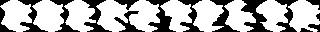

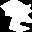

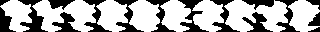

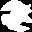

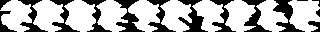

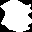

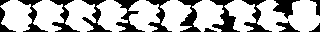

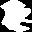

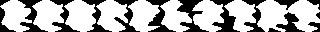

Final Results


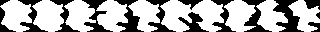

Precision: 1.00, Recall: 0.67

Query: beetle


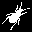

Original Results


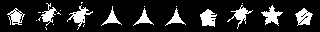

Precision: 0.30, Recall: 0.19
AQE Results with first 5 results
 


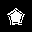

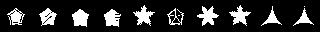

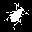

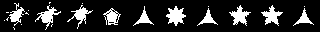

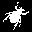

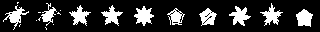

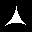

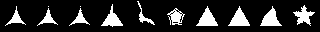

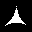

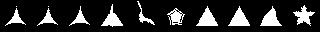

Final Results


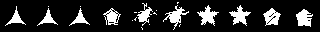

Precision: 0.20, Recall: 0.12

Query: butterfly


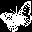

Original Results


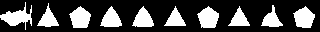

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


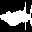

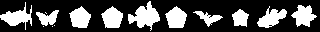

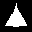

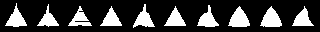

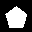

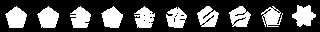

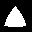

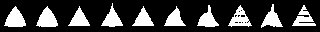

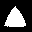

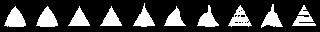

Final Results


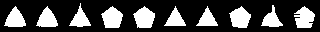

Precision: 0.00, Recall: 0.00

Query: truck


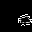

Original Results


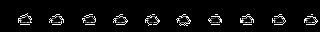

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


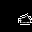

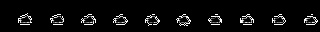

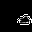

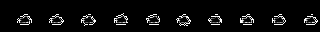

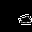

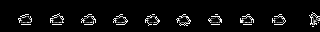

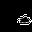

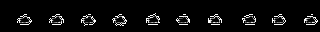

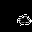

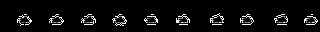

Final Results


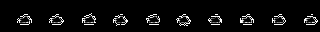

Precision: 1.00, Recall: 0.67

Query: bottle


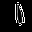

Original Results


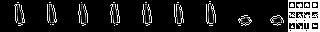

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


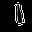

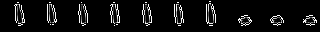

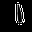

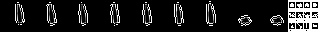

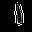

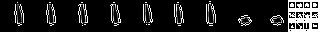

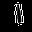

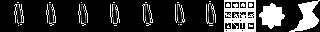

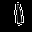

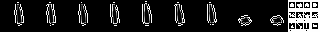

Final Results


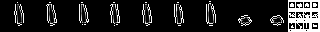

Precision: 0.70, Recall: 0.50

Query: lmfish


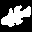

Original Results


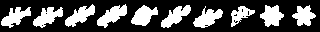

Precision: 0.60, Recall: 0.35
AQE Results with first 5 results
 


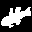

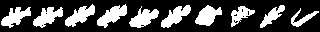

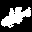

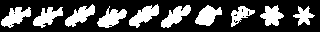

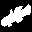

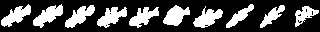

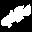

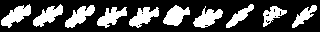

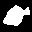

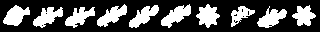

Final Results


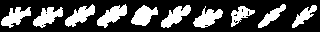

Precision: 0.80, Recall: 0.47

Query: flatfish


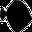

Original Results


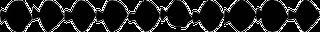

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


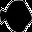

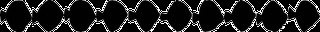

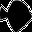

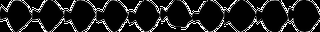

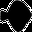

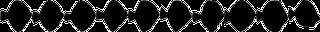

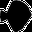

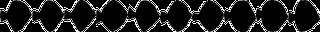

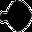

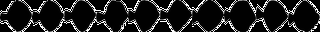

Final Results


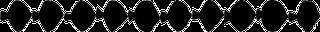

Precision: 1.00, Recall: 0.71

Query: device2


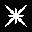

Original Results


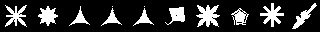

Precision: 0.40, Recall: 0.27
AQE Results with first 5 results
 


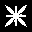

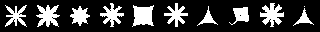

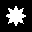

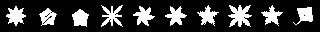

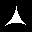

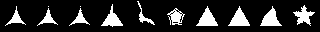

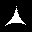

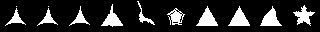

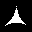

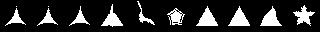

Final Results


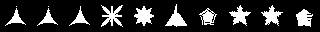

Precision: 0.20, Recall: 0.13

Query: crown


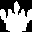

Original Results


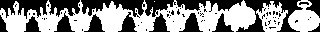

Precision: 0.80, Recall: 0.47
AQE Results with first 5 results
 


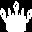

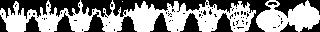

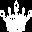

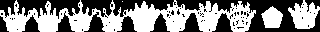

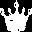

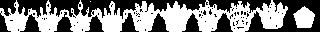

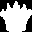

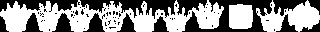

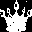

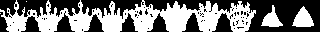

Final Results


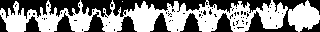

Precision: 0.90, Recall: 0.53

Query: cattle


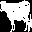

Original Results


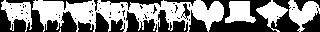

Precision: 0.60, Recall: 0.50
AQE Results with first 5 results
 


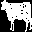

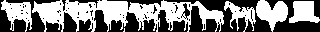

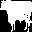

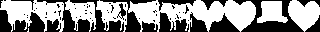

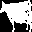

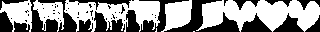

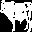

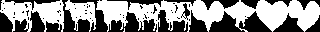

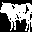

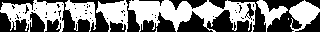

Final Results


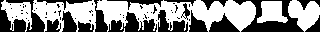

Precision: 0.60, Recall: 0.50

Query: bottle


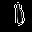

Original Results


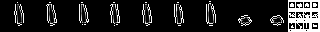

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


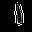

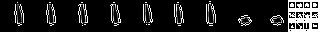

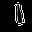

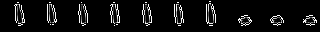

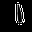

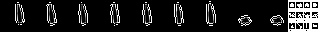

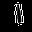

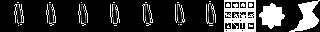

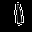

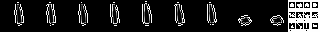

Final Results


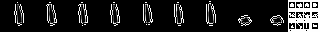

Precision: 0.70, Recall: 0.50

Query: device3


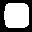

Original Results


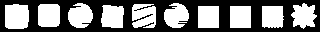

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


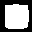

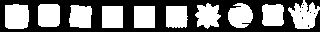

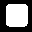

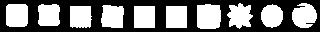

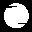

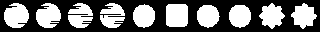

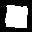

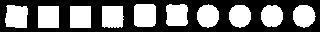

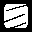

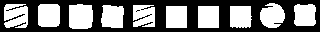

Final Results


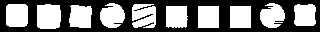

Precision: 0.80, Recall: 0.57

Query: face


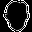

Original Results


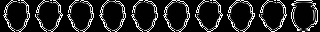

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


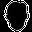

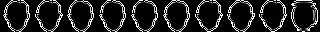

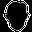

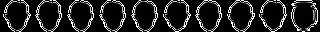

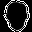

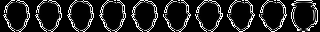

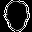

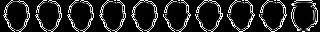

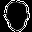

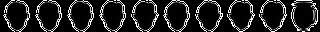

Final Results


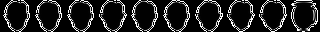

Precision: 0.90, Recall: 0.56

Query: sea_snake


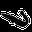

Original Results


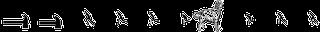

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


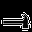

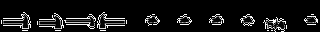

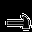

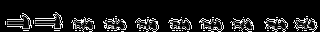

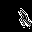

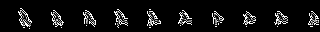

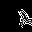

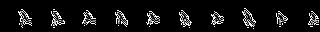

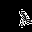

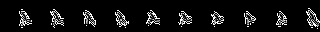

Final Results


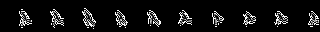

Precision: 0.00, Recall: 0.00

Query: device2


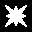

Original Results


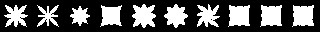

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


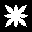

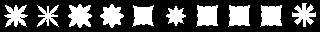

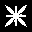

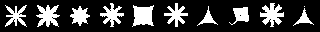

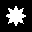

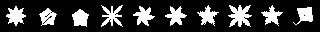

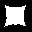

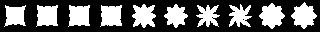

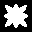

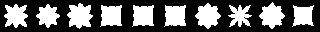

Final Results


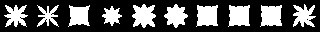

Precision: 0.60, Recall: 0.40

Query: HCircle


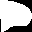

Original Results


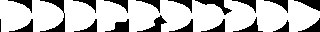

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


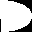

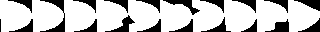

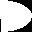

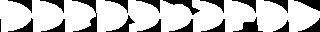

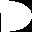

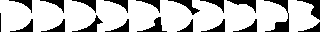

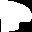

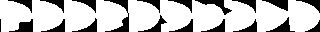

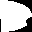

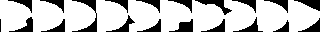

Final Results


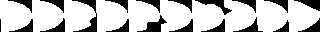

Precision: 1.00, Recall: 0.71

Query: carriage


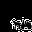

Original Results


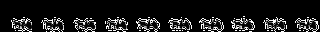

Precision: 1.00, Recall: 0.53
AQE Results with first 5 results
 


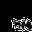

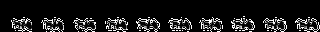

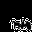

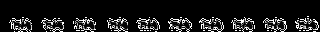

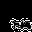

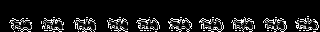

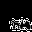

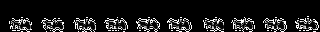

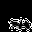

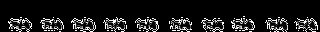

Final Results


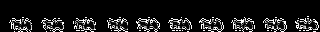

Precision: 1.00, Recall: 0.53

Query: chopper


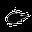

Original Results


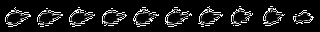

Precision: 0.90, Recall: 0.82
AQE Results with first 5 results
 


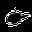

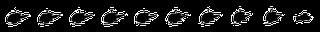

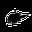

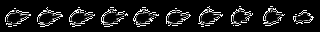

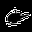

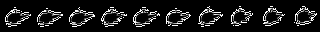

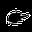

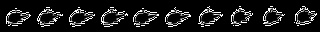

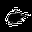

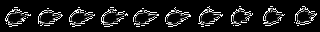

Final Results


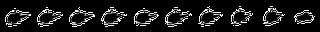

Precision: 0.90, Recall: 0.82

Query: tree


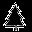

Original Results


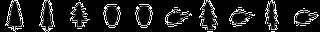

Precision: 0.50, Recall: 0.31
AQE Results with first 5 results
 


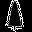

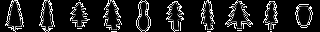

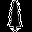

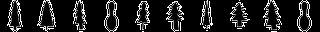

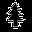

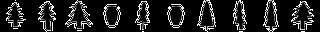

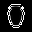

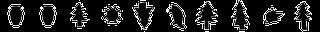

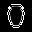

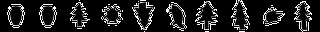

Final Results


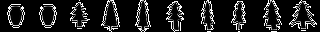

Precision: 0.80, Recall: 0.50

Query: jar


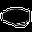

Original Results


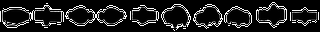

Precision: 0.30, Recall: 0.19
AQE Results with first 5 results
 


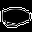

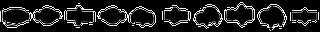

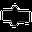

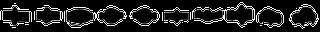

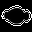

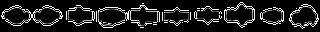

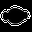

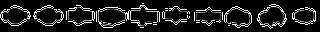

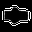

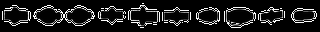

Final Results


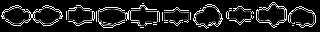

Precision: 0.30, Recall: 0.19

Query: personal_car


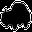

Original Results


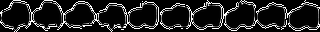

Precision: 0.40, Recall: 0.24
AQE Results with first 5 results
 


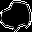

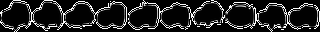

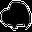

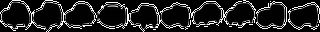

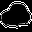

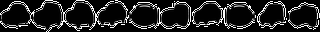

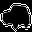

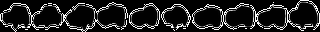

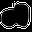

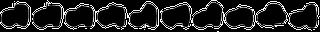

Final Results


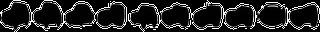

Precision: 0.40, Recall: 0.24

Query: rat


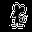

Original Results


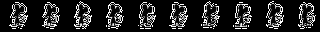

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


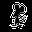

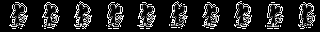

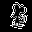

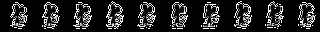

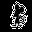

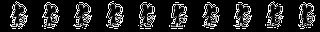

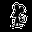

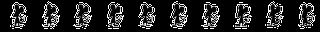

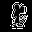

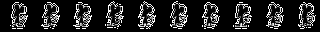

Final Results


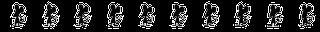

Precision: 1.00, Recall: 0.56

Query: Comma


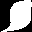

Original Results


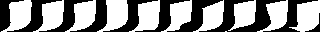

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


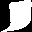

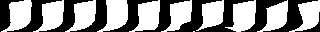

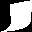

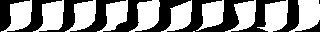

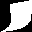

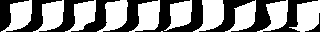

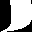

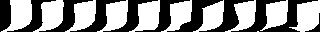

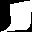

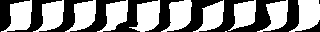

Final Results


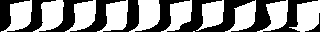

Precision: 1.00, Recall: 0.67

Query: fish


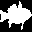

Original Results


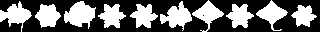

Precision: 0.30, Recall: 0.20
AQE Results with first 5 results
 


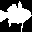

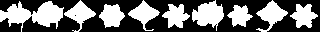

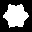

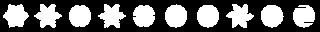

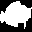

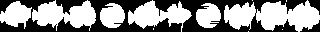

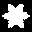

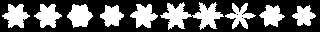

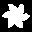

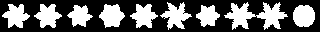

Final Results


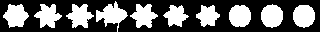

Precision: 0.10, Recall: 0.07

Query: personal_car


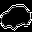

Original Results


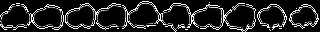

Precision: 0.60, Recall: 0.35
AQE Results with first 5 results
 


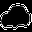

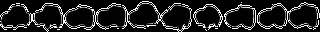

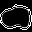

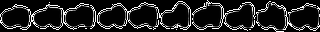

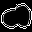

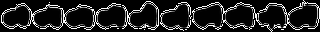

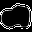

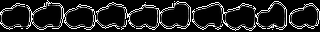

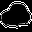

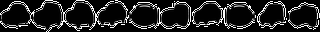

Final Results


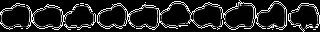

Precision: 0.30, Recall: 0.18

Query: device7


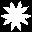

Original Results


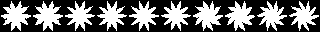

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


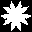

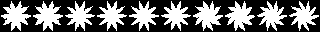

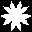

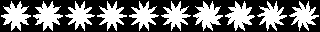

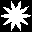

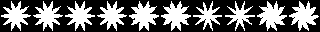

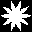

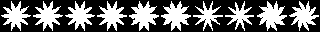

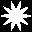

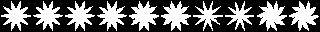

Final Results


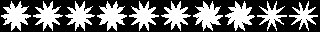

Precision: 1.00, Recall: 0.62

Query: device0


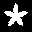

Original Results


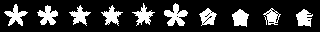

Precision: 0.60, Recall: 0.43
AQE Results with first 5 results
 


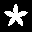

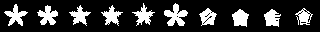

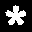

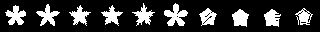

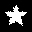

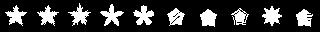

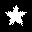

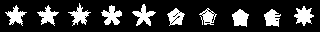

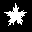

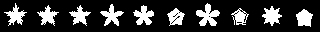

Final Results


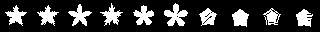

Precision: 0.60, Recall: 0.43

Query: device2


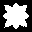

Original Results


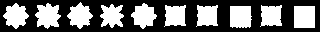

Precision: 0.50, Recall: 0.33
AQE Results with first 5 results
 


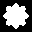

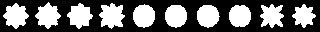

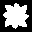

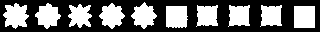

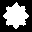

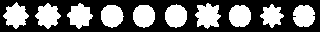

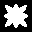

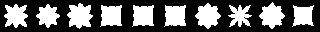

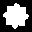

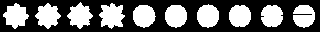

Final Results


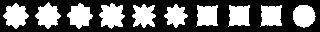

Precision: 0.60, Recall: 0.40

Query: dog


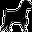

Original Results


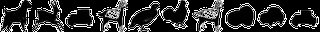

Precision: 0.30, Recall: 0.17
AQE Results with first 5 results
 


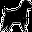

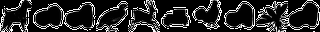

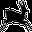

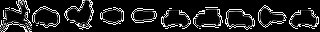

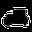

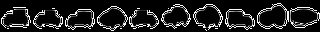

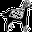

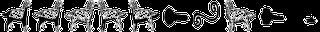

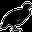

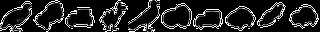

Final Results


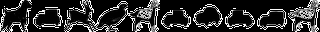

Precision: 0.30, Recall: 0.17

Query: key


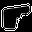

Original Results


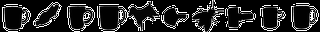

Precision: 0.20, Recall: 0.14
AQE Results with first 5 results
 


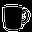

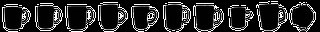

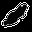

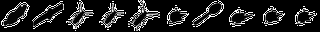

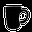

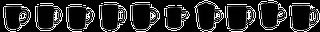

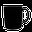

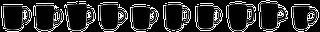

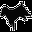

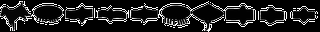

Final Results


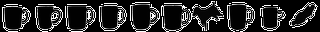

Precision: 0.00, Recall: 0.00

Query: pocket


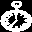

Original Results


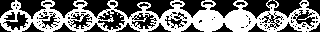

Precision: 1.00, Recall: 0.59
AQE Results with first 5 results
 


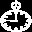

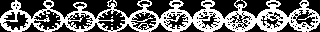

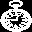

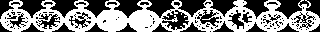

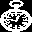

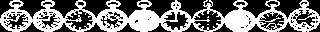

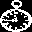

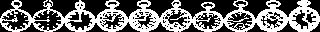

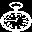

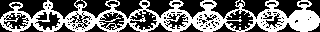

Final Results


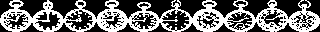

Precision: 1.00, Recall: 0.59

Query: cup


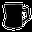

Original Results


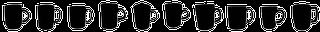

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


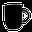

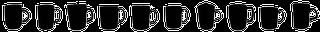

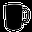

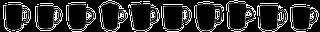

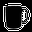

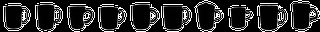

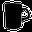

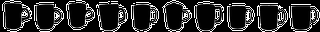

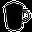

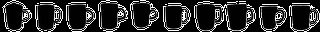

Final Results


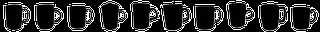

Precision: 1.00, Recall: 0.62

Query: device1


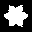

Original Results


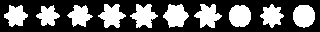

Precision: 0.70, Recall: 0.41
AQE Results with first 5 results
 


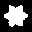

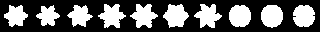

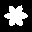

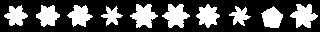

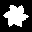

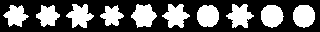

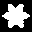

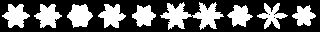

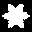

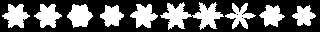

Final Results


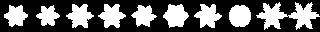

Precision: 0.90, Recall: 0.53

Query: dog


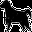

Original Results


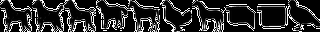

Precision: 0.40, Recall: 0.22
AQE Results with first 5 results
 


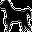

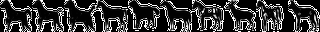

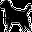

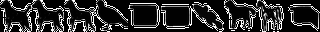

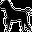

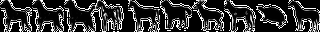

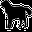

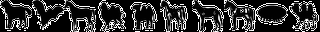

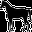

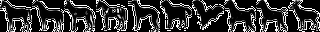

Final Results


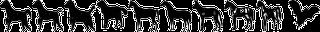

Precision: 0.50, Recall: 0.28

Query: jar


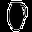

Original Results


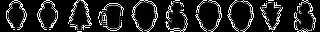

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


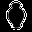

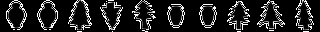

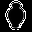

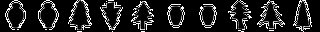

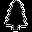

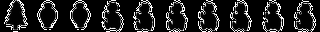

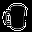

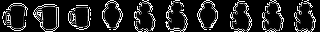

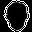

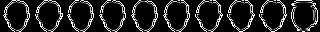

Final Results


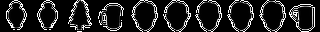

Precision: 0.20, Recall: 0.12

Query: ray


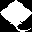

Original Results


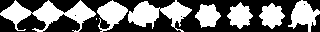

Precision: 0.50, Recall: 0.45
AQE Results with first 5 results
 


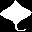

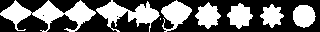

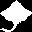

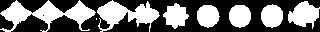

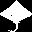

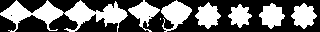

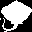

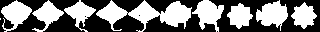

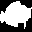

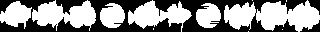

Final Results


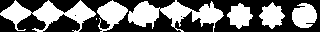

Precision: 0.50, Recall: 0.45

Query: elephant


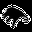

Original Results


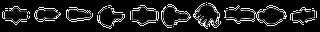

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


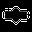

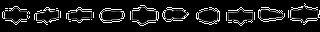

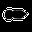

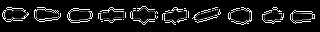

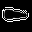

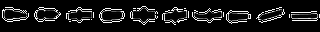

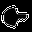

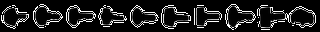

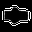

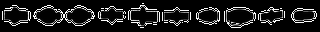

Final Results


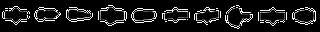

Precision: 0.00, Recall: 0.00

Query: beetle


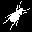

Original Results


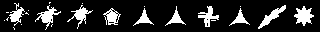

Precision: 0.30, Recall: 0.19
AQE Results with first 5 results
 


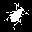

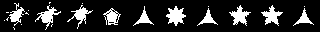

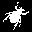

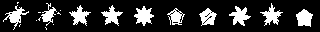

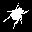

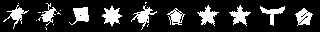

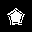

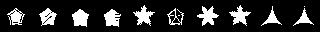

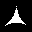

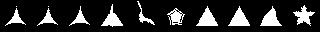

Final Results


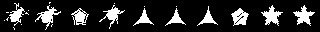

Precision: 0.30, Recall: 0.19

Query: device1


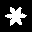

Original Results


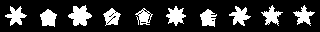

Precision: 0.30, Recall: 0.18
AQE Results with first 5 results
 


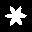

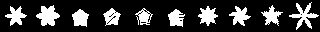

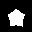

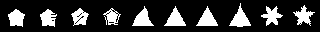

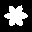

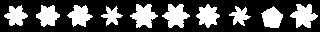

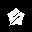

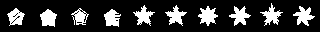

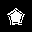

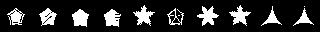

Final Results


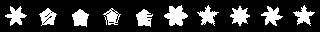

Precision: 0.30, Recall: 0.18

Query: flatfish


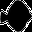

Original Results


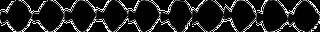

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


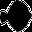

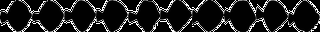

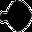

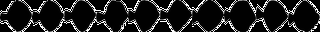

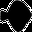

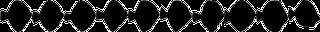

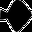

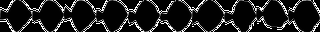

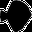

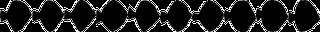

Final Results


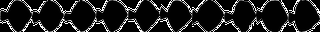

Precision: 1.00, Recall: 0.71

Query: device4


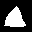

Original Results


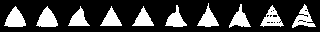

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


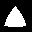

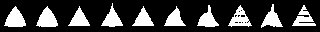

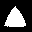

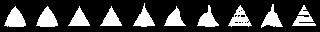

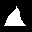

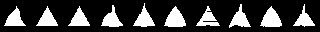

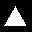

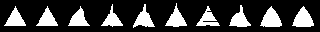

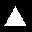

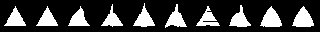

Final Results


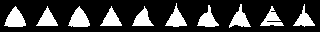

Precision: 1.00, Recall: 0.62

Query: deer


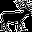

Original Results


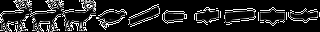

Precision: 0.30, Recall: 0.16
AQE Results with first 5 results
 


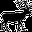

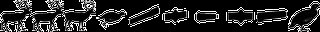

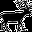

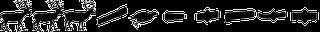

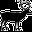

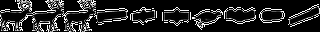

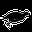

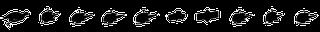

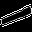

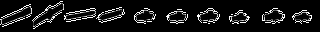

Final Results


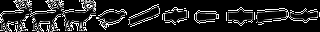

Precision: 0.30, Recall: 0.16

Query: octopus


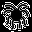

Original Results


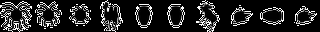

Precision: 0.30, Recall: 0.23
AQE Results with first 5 results
 


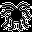

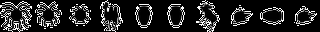

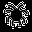

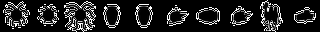

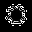

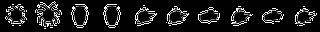

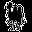

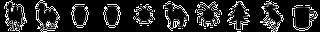

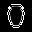

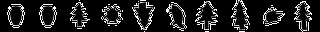

Final Results


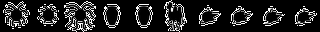

Precision: 0.30, Recall: 0.23

Query: device1


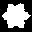

Original Results


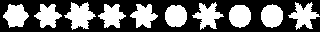

Precision: 0.70, Recall: 0.41
AQE Results with first 5 results
 


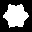

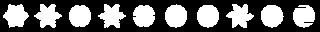

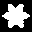

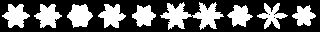

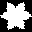

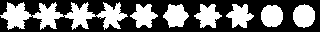

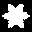

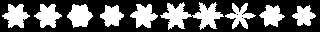

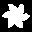

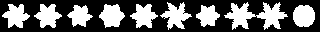

Final Results


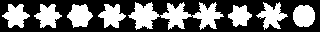

Precision: 0.90, Recall: 0.53

Query: device5


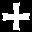

Original Results


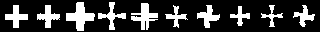

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


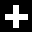

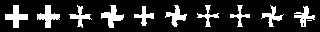

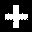

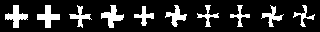

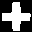

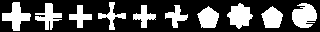

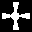

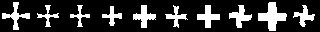

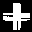

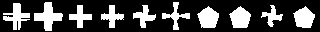

Final Results


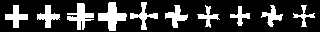

Precision: 1.00, Recall: 0.71

Query: horse


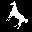

Original Results


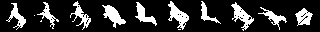

Precision: 0.40, Recall: 0.27
AQE Results with first 5 results
 


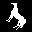

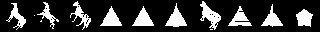

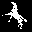

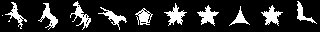

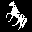

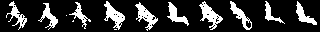

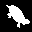

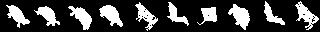

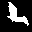

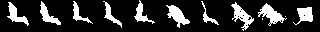

Final Results


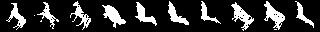

Precision: 0.30, Recall: 0.20

Query: device0


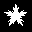

Original Results


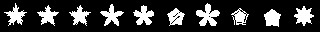

Precision: 0.60, Recall: 0.43
AQE Results with first 5 results
 


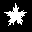

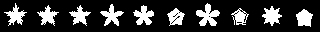

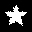

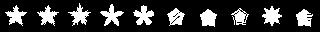

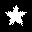

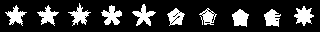

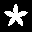

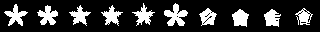

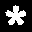

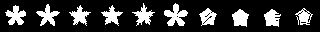

Final Results


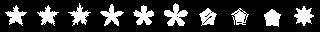

Precision: 0.60, Recall: 0.43

Query: turtle


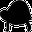

Original Results


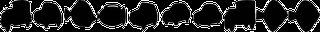

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


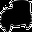

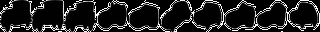

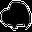

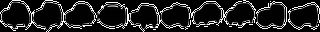

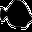

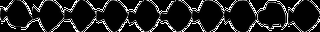

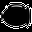

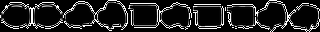

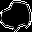

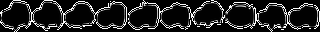

Final Results


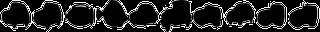

Precision: 0.00, Recall: 0.00

Query: flatfish


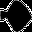

Original Results


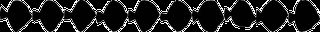

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


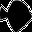

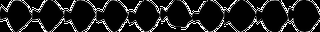

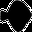

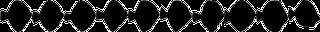

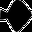

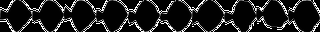

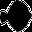

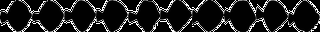

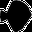

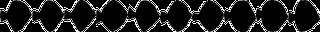

Final Results


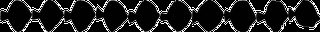

Precision: 1.00, Recall: 0.71

Query: hammer


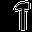

Original Results


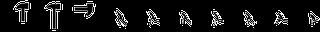

Precision: 0.30, Recall: 0.19
AQE Results with first 5 results
 


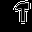

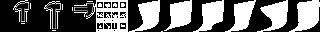

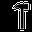

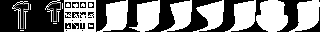

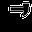

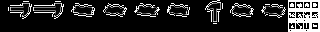

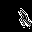

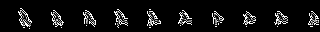

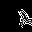

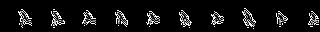

Final Results


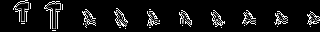

Precision: 0.20, Recall: 0.12

Query: device0


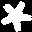

Original Results


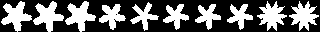

Precision: 0.80, Recall: 0.57
AQE Results with first 5 results
 


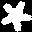

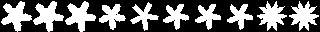

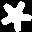

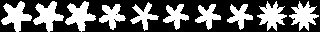

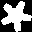

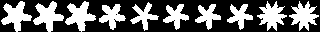

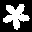

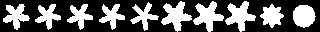

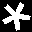

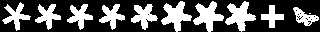

Final Results


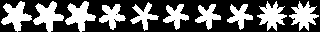

Precision: 0.80, Recall: 0.57

Query: horseshoe


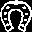

Original Results


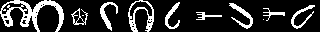

Precision: 0.30, Recall: 0.20
AQE Results with first 5 results
 


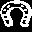

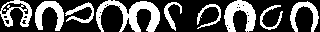

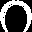

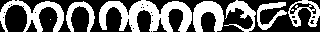

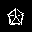

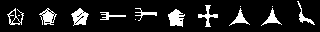

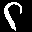

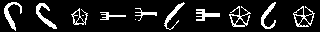

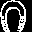

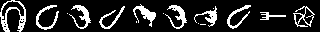

Final Results


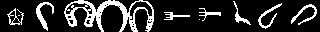

Precision: 0.30, Recall: 0.20

Query: classic


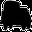

Original Results


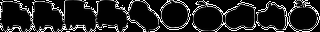

Precision: 0.50, Recall: 0.28
AQE Results with first 5 results
 


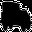

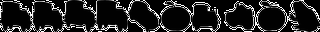

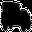

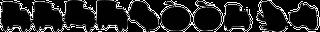

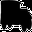

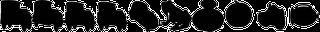

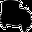

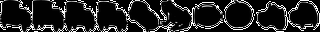

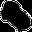

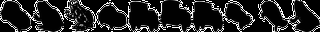

Final Results


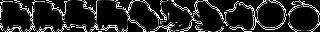

Precision: 0.50, Recall: 0.28

Query: hammer


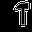

Original Results


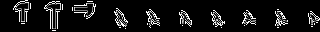

Precision: 0.30, Recall: 0.19
AQE Results with first 5 results
 


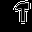

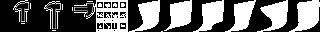

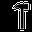

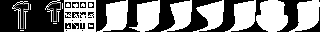

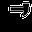

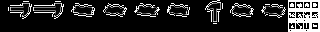

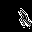

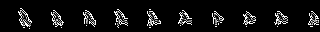

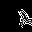

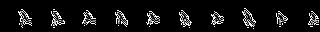

Final Results


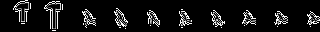

Precision: 0.20, Recall: 0.12

Query: brick


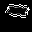

Original Results


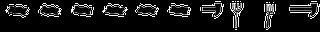

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


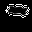

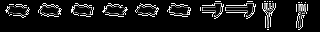

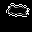

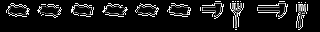

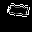

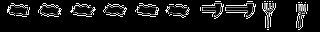

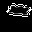

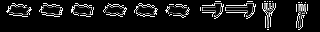

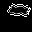

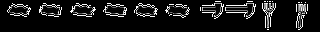

Final Results


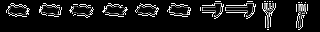

Precision: 0.60, Recall: 0.40

Query: camel


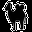

Original Results


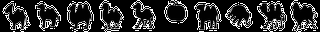

Precision: 0.80, Recall: 0.44
AQE Results with first 5 results
 


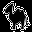

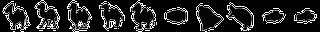

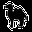

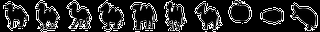

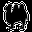

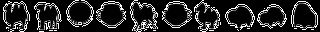

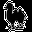

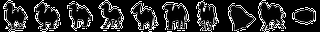

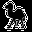

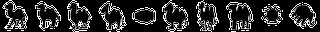

Final Results


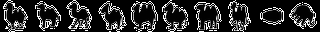

Precision: 0.80, Recall: 0.44

Query: Glas


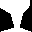

Original Results


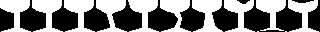

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


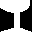

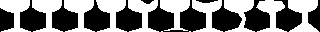

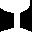

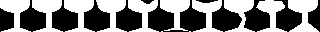

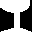

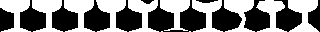

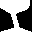

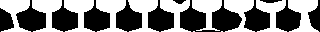

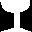

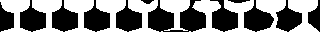

Final Results


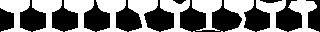

Precision: 1.00, Recall: 0.71

Query: fork


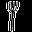

Original Results


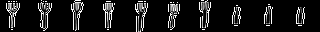

Precision: 0.70, Recall: 0.54
AQE Results with first 5 results
 


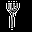

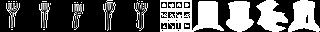

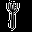

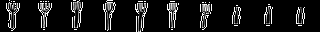

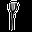

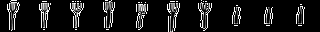

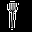

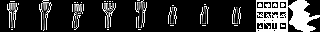

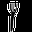

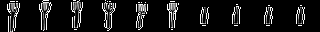

Final Results


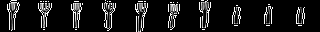

Precision: 0.70, Recall: 0.54

Query: spoon


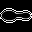

Original Results


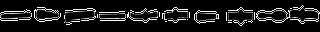

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


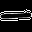

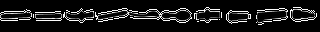

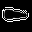

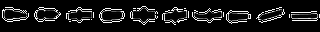

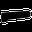

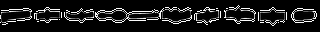

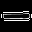

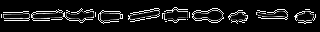

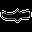

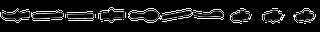

Final Results


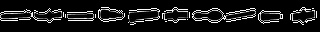

Precision: 0.10, Recall: 0.06

Query: pencil


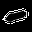

Original Results


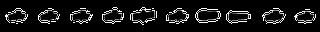

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


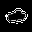

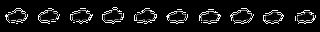

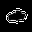

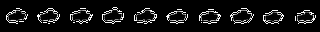

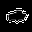

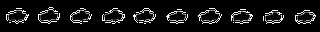

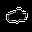

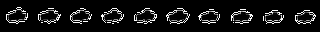

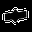

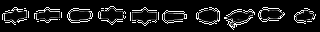

Final Results


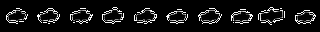

Precision: 0.00, Recall: 0.00

Query: Comma


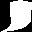

Original Results


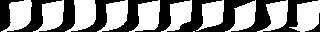

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


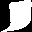

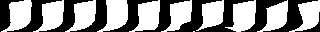

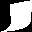

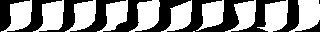

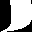

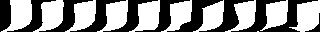

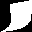

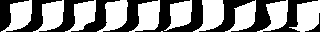

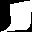

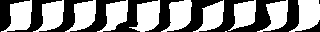

Final Results


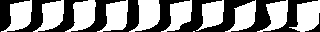

Precision: 1.00, Recall: 0.67

Query: Misk


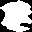

Original Results


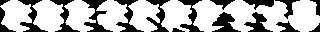

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


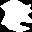

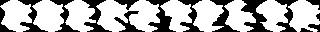

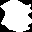

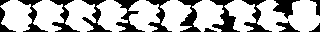

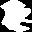

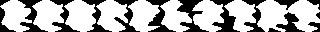

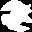

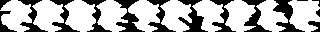

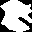

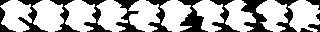

Final Results


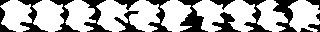

Precision: 1.00, Recall: 0.67

Query: cup


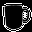

Original Results


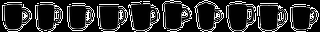

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


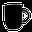

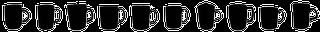

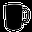

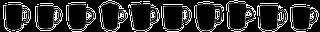

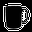

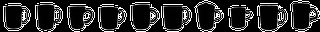

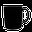

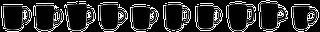

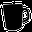

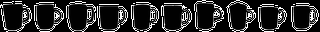

Final Results


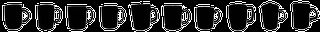

Precision: 1.00, Recall: 0.62

Query: device9


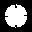

Original Results


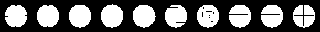

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


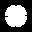

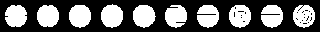

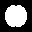

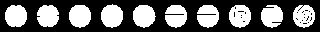

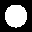

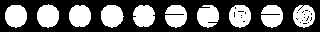

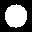

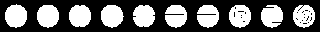

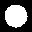

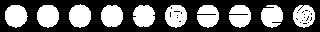

Final Results


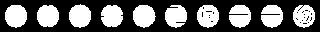

Precision: 1.00, Recall: 0.67

Query: cup


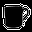

Original Results


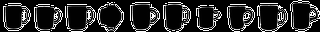

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


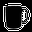

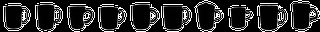

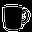

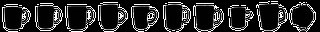

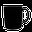

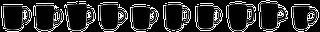

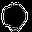

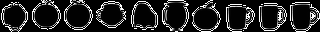

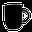

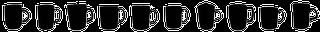

Final Results


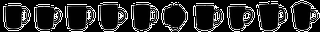

Precision: 0.90, Recall: 0.56

Query: lizzard


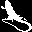

Original Results


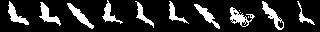

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


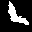

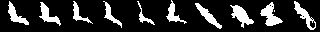

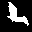

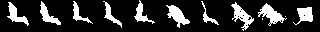

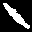

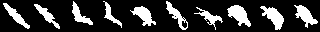

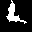

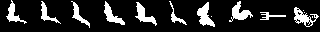

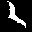

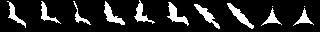

Final Results


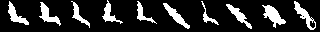

Precision: 0.10, Recall: 0.06

Query: car


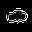

Original Results


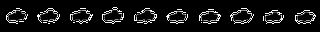

Precision: 1.00, Recall: 0.59
AQE Results with first 5 results
 


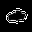

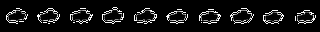

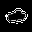

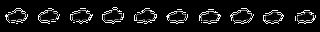

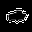

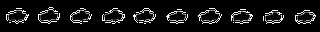

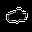

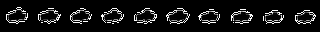

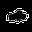

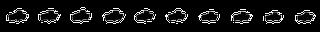

Final Results


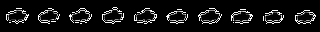

Precision: 1.00, Recall: 0.59

Query: horseshoe


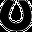

Original Results


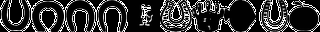

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


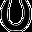

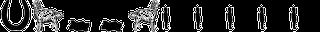

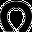

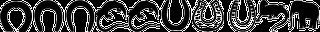

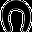

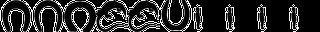

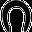

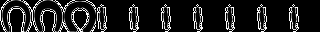

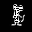

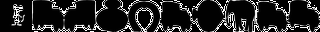

Final Results


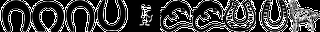

Precision: 0.60, Recall: 0.40

Query: guitar


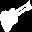

Original Results


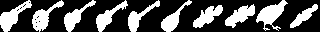

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


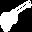

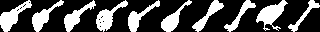

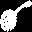

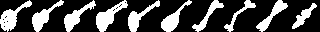

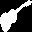

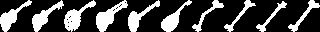

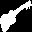

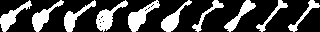

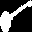

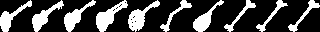

Final Results


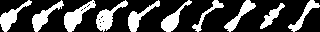

Precision: 0.60, Recall: 0.40

Query: chicken


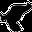

Original Results


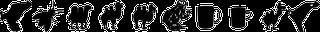

Precision: 0.10, Recall: 0.05
AQE Results with first 5 results
 


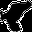

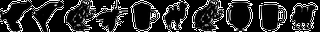

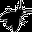

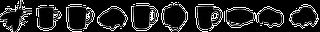

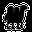

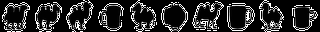

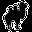

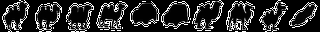

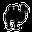

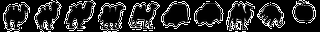

Final Results


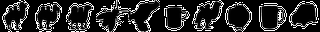

Precision: 0.10, Recall: 0.05

Query: device2


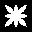

Original Results


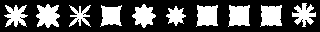

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


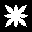

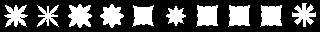

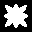

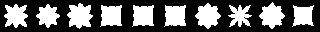

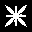

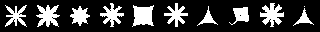

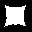

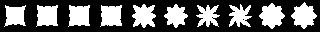

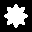

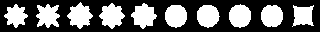

Final Results


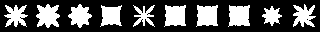

Precision: 0.60, Recall: 0.40

Query: teddy


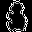

Original Results


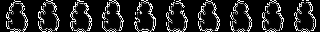

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


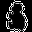

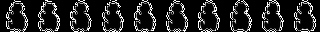

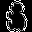

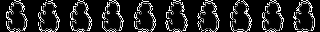

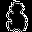

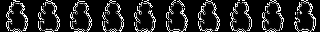

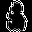

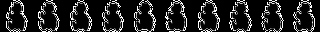

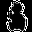

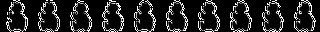

Final Results


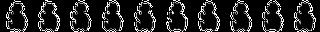

Precision: 1.00, Recall: 0.56

Query: tree


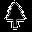

Original Results


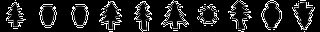

Precision: 0.60, Recall: 0.38
AQE Results with first 5 results
 


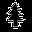

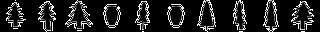

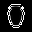

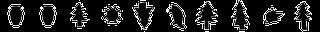

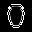

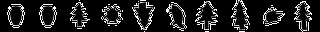

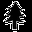

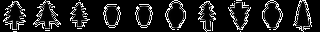

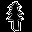

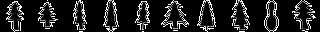

Final Results


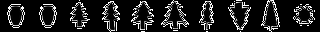

Precision: 0.70, Recall: 0.44

Query: cellular_phone


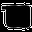

Original Results


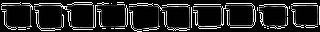

Precision: 1.00, Recall: 0.77
AQE Results with first 5 results
 


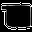

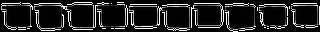

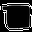

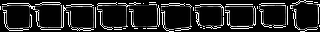

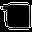

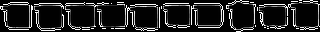

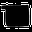

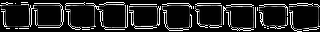

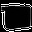

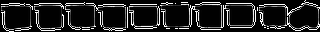

Final Results


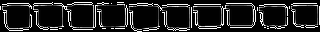

Precision: 1.00, Recall: 0.77

Query: cattle


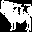

Original Results


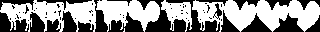

Precision: 0.60, Recall: 0.50
AQE Results with first 5 results
 


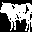

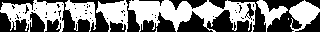

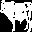

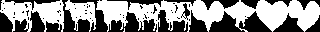

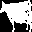

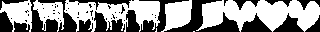

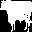

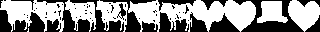

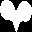

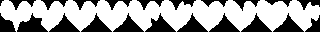

Final Results


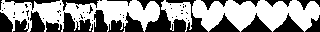

Precision: 0.50, Recall: 0.42

Query: pencil


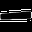

Original Results


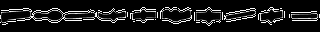

Precision: 0.40, Recall: 0.25
AQE Results with first 5 results
 


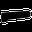

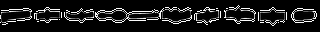

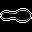

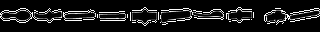

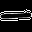

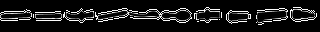

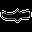

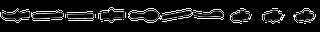

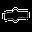

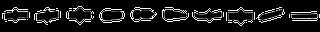

Final Results


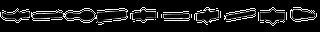

Precision: 0.50, Recall: 0.31

Query: cellular_phone


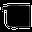

Original Results


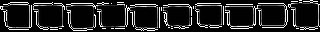

Precision: 1.00, Recall: 0.77
AQE Results with first 5 results
 


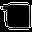

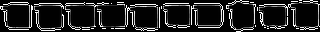

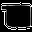

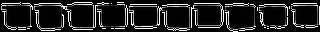

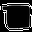

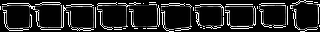

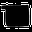

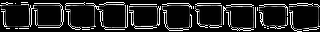

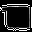

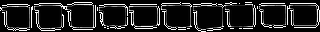

Final Results


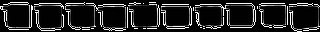

Precision: 1.00, Recall: 0.77

Query: hat


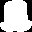

Original Results


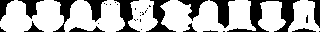

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


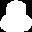

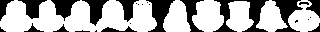

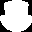

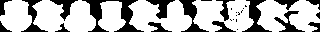

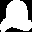

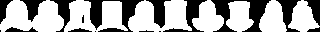

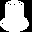

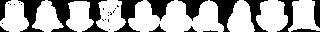

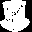

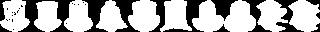

Final Results


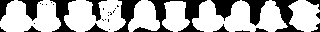

Precision: 0.80, Recall: 0.53

Query: ray


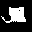

Original Results


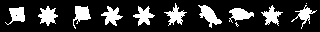

Precision: 0.20, Recall: 0.18
AQE Results with first 5 results
 


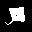

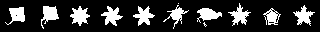

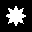

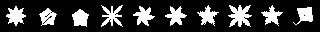

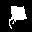

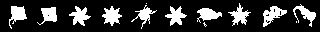

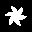

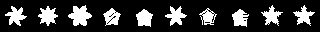

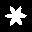

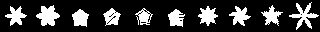

Final Results


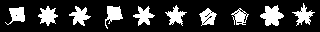

Precision: 0.20, Recall: 0.18

Query: Heart


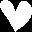

Original Results


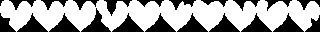

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


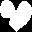

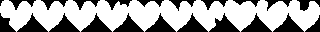

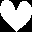

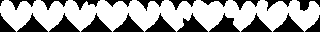

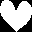

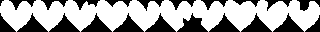

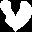

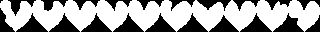

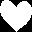

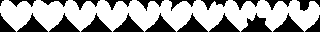

Final Results


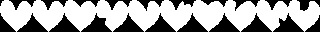

Precision: 1.00, Recall: 0.56

Query: teddy


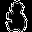

Original Results


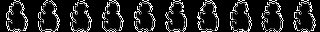

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


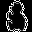

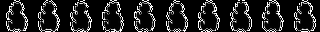

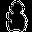

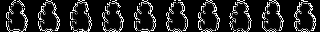

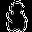

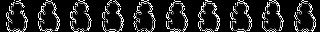

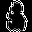

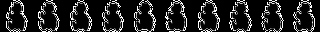

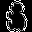

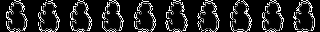

Final Results


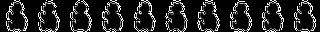

Precision: 1.00, Recall: 0.56

Query: spoon


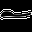

Original Results


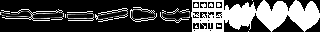

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


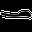

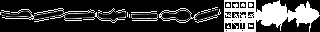

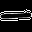

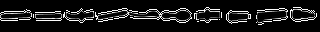

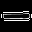

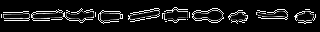

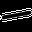

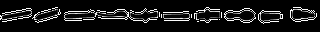

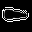

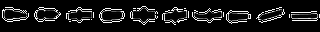

Final Results


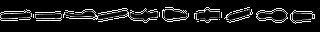

Precision: 0.20, Recall: 0.12

Query: octopus


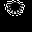

Original Results


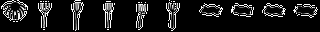

Precision: 0.10, Recall: 0.08
AQE Results with first 5 results
 


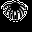

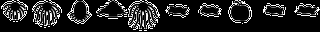

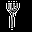

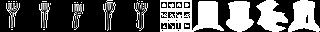

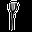

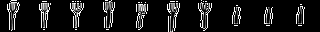

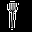

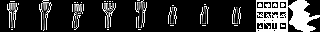

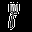

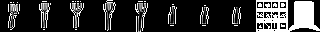

Final Results


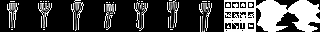

Precision: 0.00, Recall: 0.00

Query: cattle


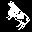

Original Results


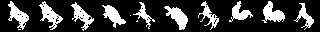

Precision: 0.30, Recall: 0.25
AQE Results with first 5 results
 


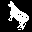

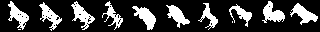

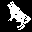

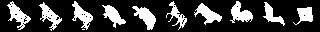

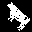

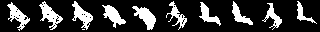

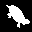

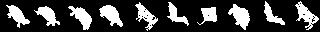

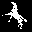

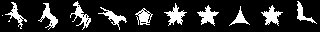

Final Results


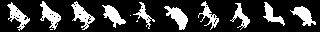

Precision: 0.30, Recall: 0.25

Query: face


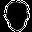

Original Results


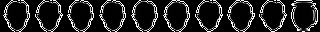

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


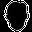

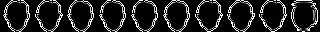

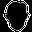

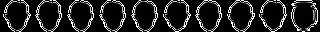

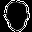

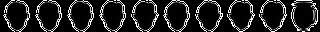

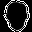

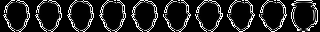

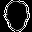

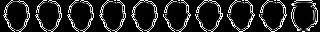

Final Results


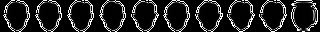

Precision: 0.90, Recall: 0.56

Query: Misk


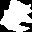

Original Results


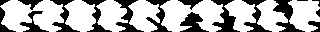

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


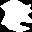

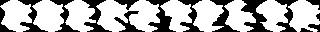

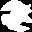

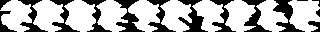

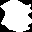

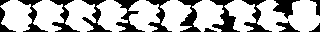

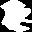

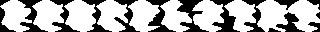

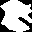

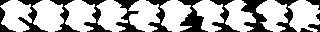

Final Results


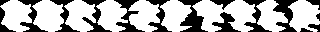

Precision: 1.00, Recall: 0.67

Query: ray


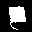

Original Results


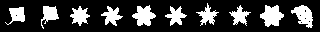

Precision: 0.20, Recall: 0.18
AQE Results with first 5 results
 


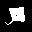

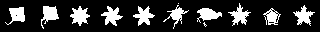

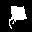

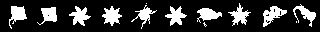

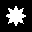

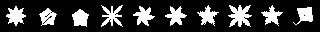

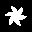

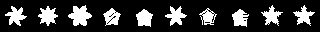

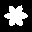

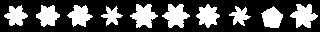

Final Results


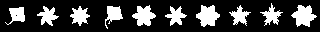

Precision: 0.20, Recall: 0.18

Query: device8


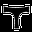

Original Results


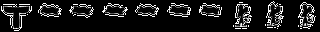

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


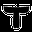

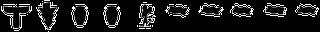

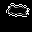

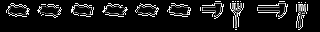

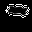

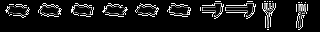

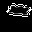

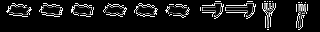

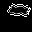

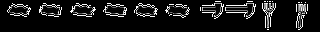

Final Results


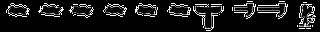

Precision: 0.10, Recall: 0.06

Query: ray


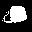

Original Results


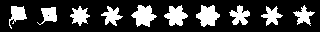

Precision: 0.20, Recall: 0.18
AQE Results with first 5 results
 


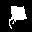

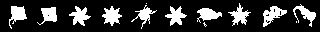

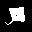

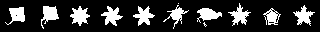

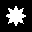

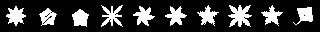

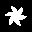

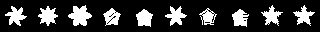

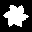

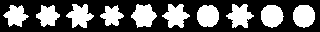

Final Results


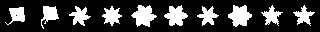

Precision: 0.20, Recall: 0.18

Query: camel


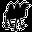

Original Results


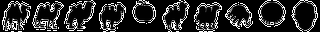

Precision: 0.60, Recall: 0.33
AQE Results with first 5 results
 


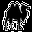

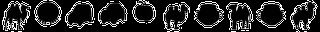

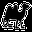

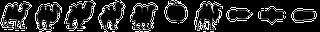

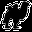

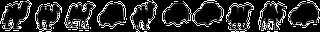

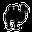

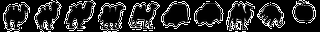

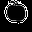

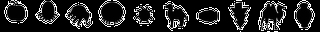

Final Results


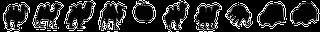

Precision: 0.60, Recall: 0.33

Query: tree


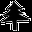

Original Results


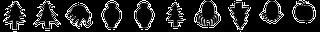

Precision: 0.40, Recall: 0.25
AQE Results with first 5 results
 


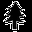

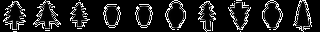

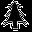

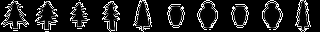

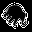

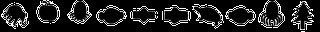

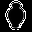

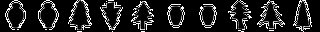

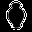

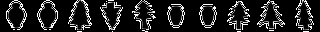

Final Results


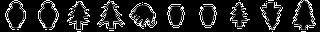

Precision: 0.50, Recall: 0.31

Query: frog


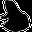

Original Results


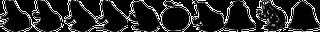

Precision: 0.70, Recall: 0.41
AQE Results with first 5 results
 


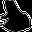

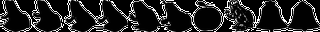

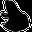

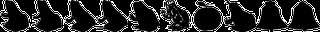

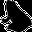

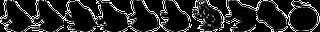

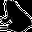

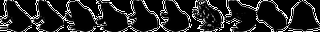

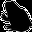

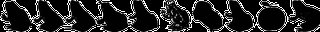

Final Results


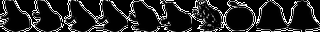

Precision: 0.70, Recall: 0.41

Query: device2


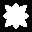

Original Results


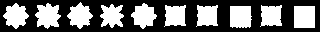

Precision: 0.50, Recall: 0.33
AQE Results with first 5 results
 


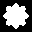

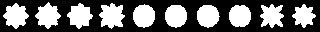

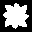

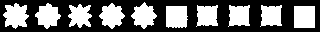

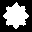

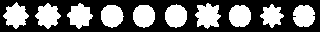

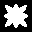

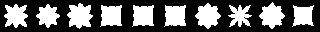

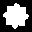

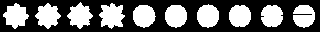

Final Results


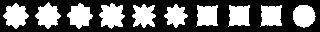

Precision: 0.60, Recall: 0.40

Query: beetle


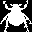

Original Results


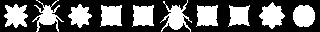

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


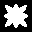

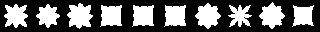

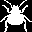

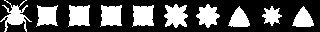

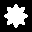

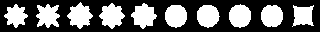

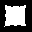

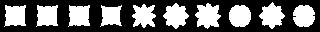

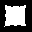

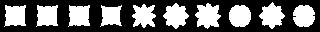

Final Results


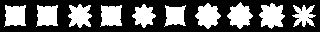

Precision: 0.00, Recall: 0.00

Query: brick


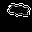

Original Results


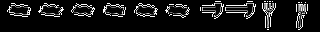

Precision: 0.60, Recall: 0.40
AQE Results with first 5 results
 


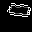

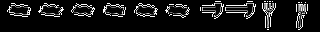

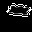

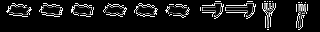

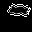

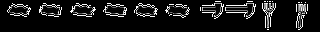

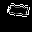

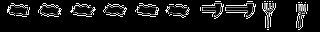

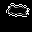

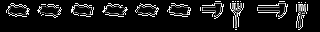

Final Results


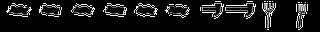

Precision: 0.60, Recall: 0.40

Query: fly


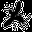

Original Results


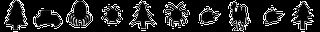

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


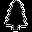

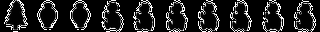

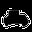

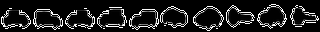

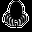

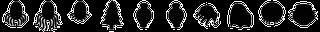

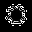

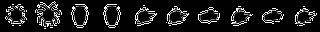

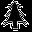

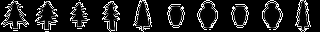

Final Results


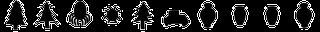

Precision: 0.00, Recall: 0.00

Query: hammer


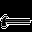

Original Results


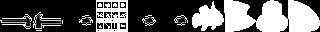

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


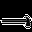

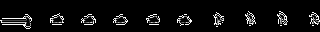

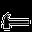

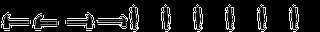

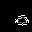

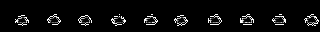

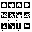

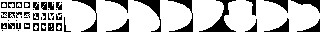

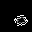

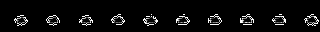

Final Results


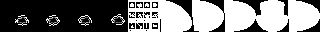

Precision: 0.00, Recall: 0.00

Query: device0


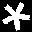

Original Results


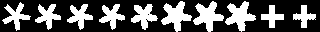

Precision: 0.80, Recall: 0.57
AQE Results with first 5 results
 


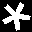

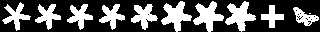

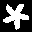

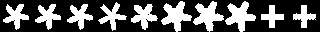

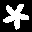

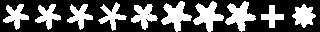

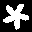

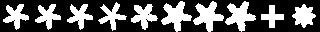

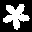

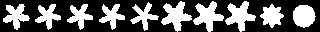

Final Results


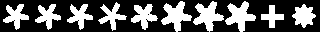

Precision: 0.80, Recall: 0.57

Query: fish


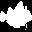

Original Results


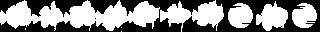

Precision: 0.80, Recall: 0.53
AQE Results with first 5 results
 


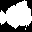

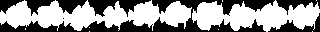

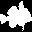

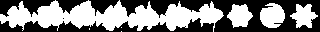

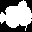

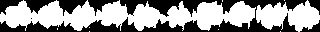

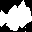

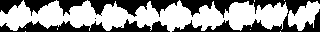

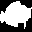

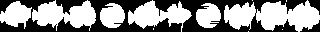

Final Results


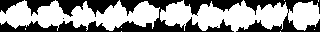

Precision: 1.00, Recall: 0.67

Query: fish


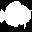

Original Results


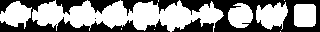

Precision: 0.80, Recall: 0.53
AQE Results with first 5 results
 


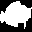

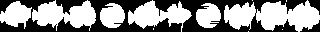

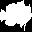

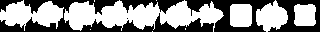

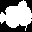

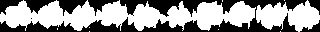

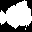

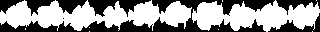

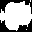

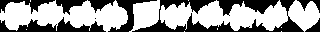

Final Results


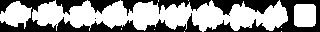

Precision: 0.90, Recall: 0.60

Query: sea_snake


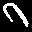

Original Results


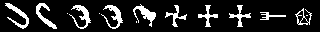

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


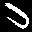

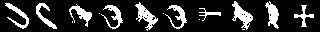

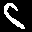

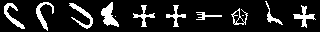

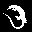

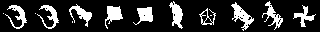

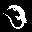

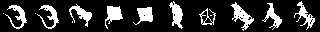

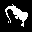

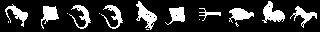

Final Results


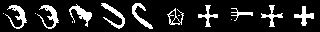

Precision: 0.20, Recall: 0.12

Query: lizzard


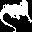

Original Results


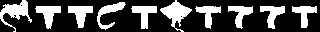

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


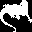

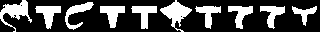

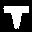

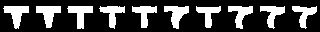

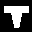

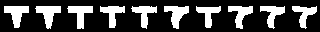

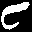

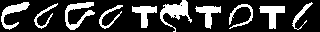

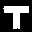

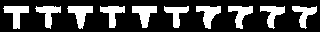

Final Results


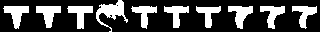

Precision: 0.10, Recall: 0.06

Query: truck


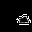

Original Results


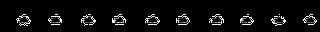

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


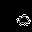

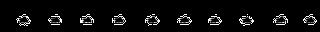

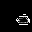

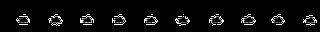

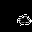

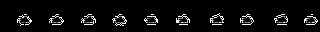

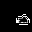

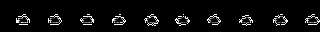

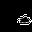

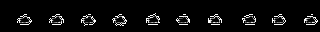

Final Results


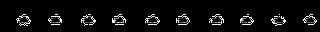

Precision: 1.00, Recall: 0.67

Query: lmfish


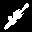

Original Results


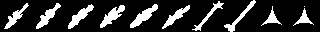

Precision: 0.60, Recall: 0.35
AQE Results with first 5 results
 


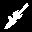

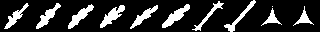

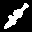

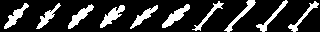

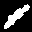

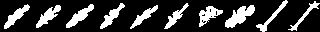

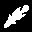

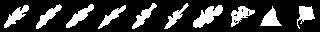

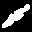

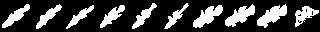

Final Results


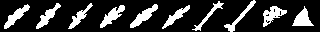

Precision: 0.60, Recall: 0.35

Query: watch


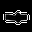

Original Results


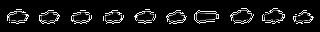

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


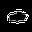

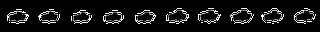

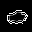

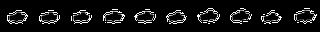

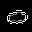

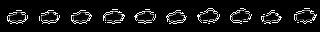

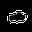

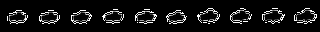

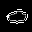

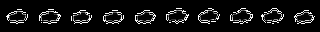

Final Results


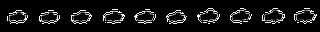

Precision: 0.00, Recall: 0.00

Query: octopus


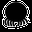

Original Results


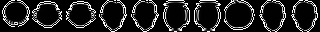

Precision: 0.10, Recall: 0.08
AQE Results with first 5 results
 


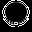

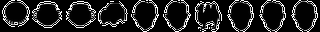

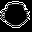

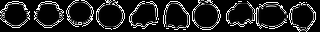

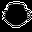

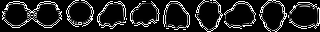

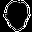

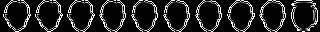

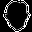

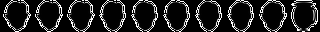

Final Results


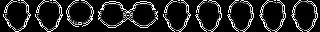

Precision: 0.10, Recall: 0.08

Query: classic


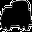

Original Results


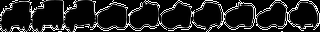

Precision: 0.30, Recall: 0.17
AQE Results with first 5 results
 


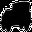

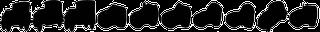

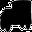

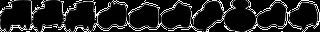

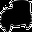

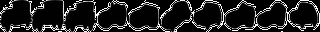

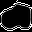

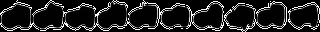

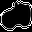

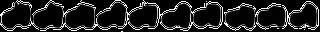

Final Results


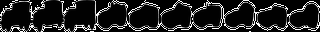

Precision: 0.30, Recall: 0.17

Query: brick


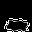

Original Results


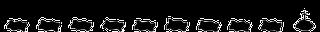

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


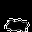

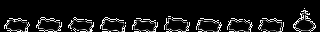

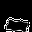

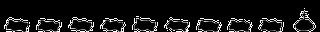

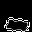

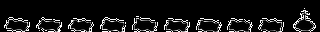

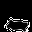

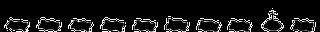

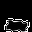

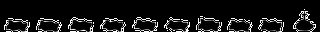

Final Results


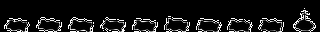

Precision: 0.90, Recall: 0.60

Query: turtle


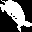

Original Results


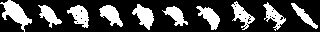

Precision: 0.70, Recall: 0.39
AQE Results with first 5 results
 


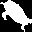

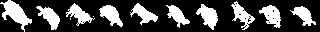

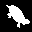

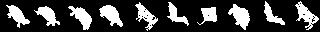

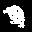

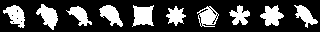

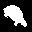

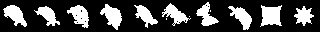

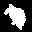

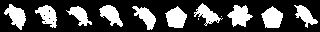

Final Results


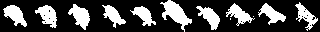

Precision: 0.70, Recall: 0.39

Query: spring


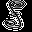

Original Results


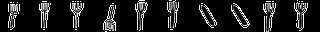

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


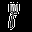

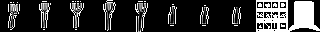

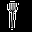

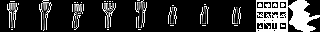

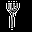

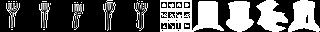

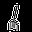

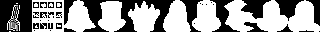

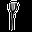

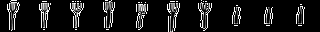

Final Results


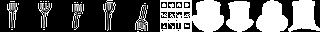

Precision: 0.00, Recall: 0.00

Query: ray


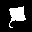

Original Results


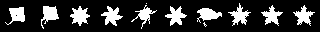

Precision: 0.20, Recall: 0.18
AQE Results with first 5 results
 


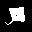

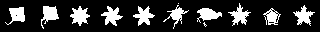

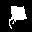

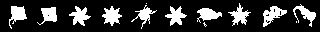

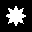

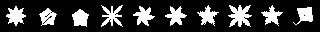

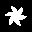

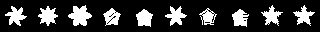

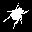

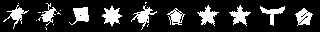

Final Results


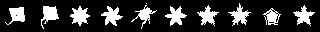

Precision: 0.20, Recall: 0.18

Query: hat


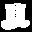

Original Results


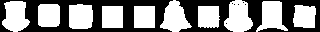

Precision: 0.30, Recall: 0.20
AQE Results with first 5 results
 


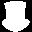

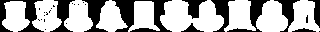

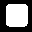

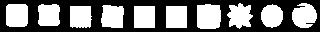

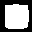

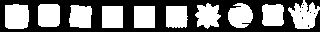

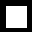

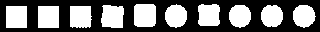

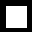

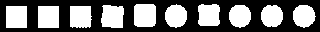

Final Results


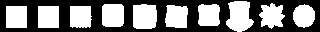

Precision: 0.10, Recall: 0.07

Query: bottle


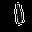

Original Results


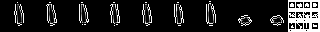

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


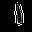

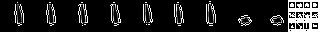

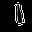

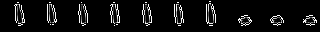

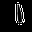

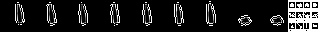

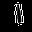

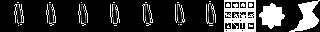

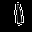

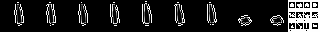

Final Results


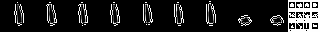

Precision: 0.70, Recall: 0.50

Query: device7


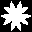

Original Results


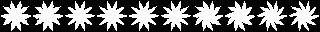

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


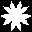

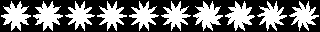

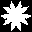

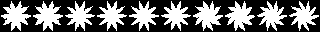

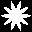

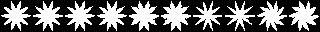

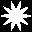

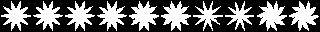

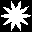

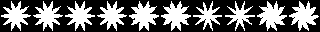

Final Results


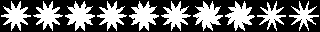

Precision: 1.00, Recall: 0.62

Query: device7


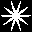

Original Results


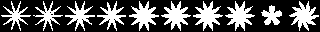

Precision: 0.90, Recall: 0.56
AQE Results with first 5 results
 


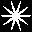

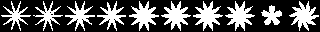

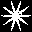

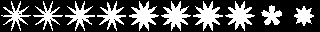

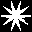

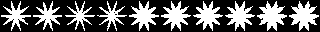

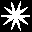

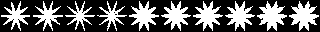

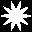

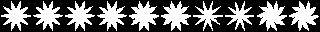

Final Results


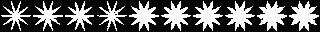

Precision: 1.00, Recall: 0.62

Query: sea_snake


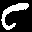

Original Results


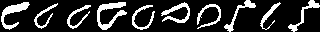

Precision: 0.80, Recall: 0.47
AQE Results with first 5 results
 


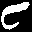

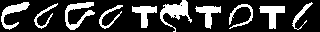

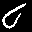

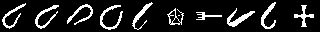

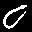

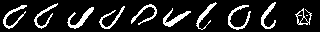

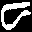

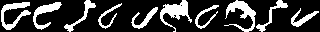

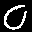

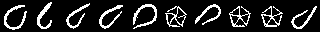

Final Results


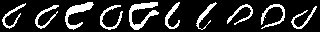

Precision: 1.00, Recall: 0.59

Query: butterfly


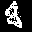

Original Results


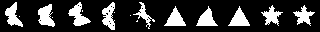

Precision: 0.40, Recall: 0.29
AQE Results with first 5 results
 


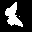

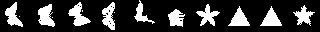

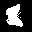

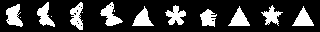

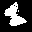

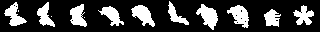

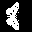

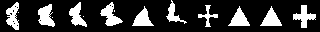

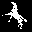

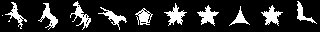

Final Results


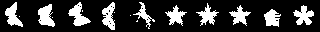

Precision: 0.40, Recall: 0.29

Query: spoon


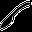

Original Results


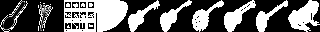

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


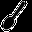

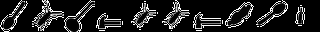

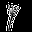

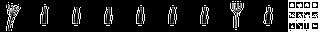

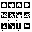

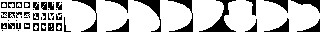

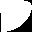

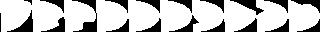

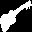

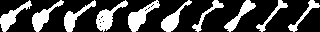

Final Results


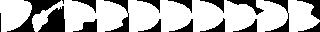

Precision: 0.00, Recall: 0.00

Query: ray


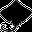

Original Results


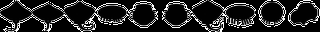

Precision: 0.40, Recall: 0.36
AQE Results with first 5 results
 


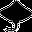

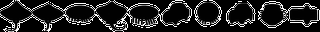

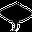

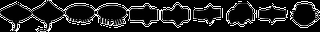

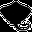

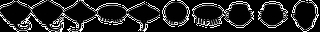

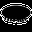

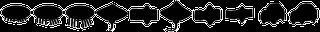

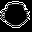

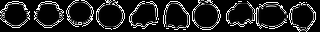

Final Results


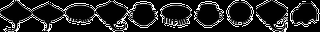

Precision: 0.40, Recall: 0.36

Query: Glas


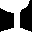

Original Results


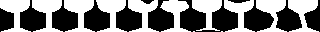

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


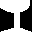

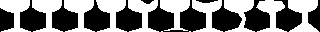

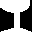

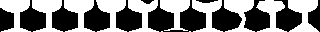

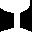

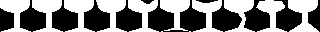

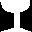

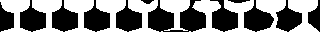

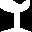

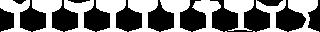

Final Results


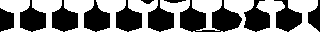

Precision: 1.00, Recall: 0.71

Query: frog


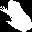

Original Results


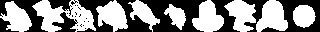

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


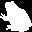

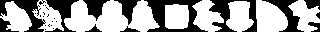

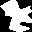

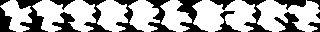

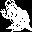

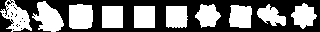

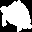

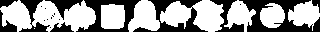

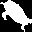

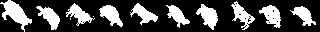

Final Results


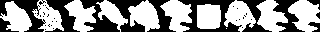

Precision: 0.20, Recall: 0.12

Query: brick


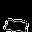

Original Results


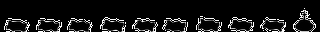

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


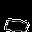

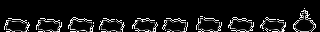

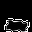

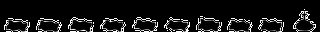

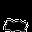

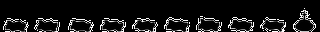

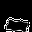

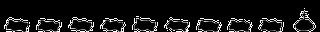

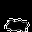

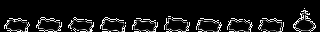

Final Results


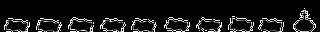

Precision: 0.90, Recall: 0.60

Query: device5


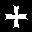

Original Results


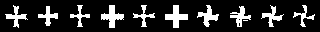

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


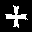

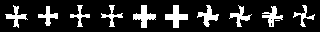

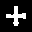

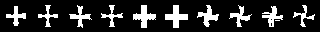

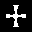

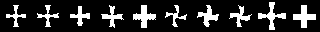

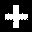

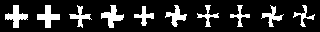

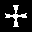

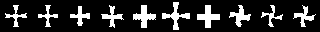

Final Results


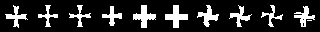

Precision: 1.00, Recall: 0.71

Query: tree


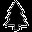

Original Results


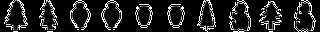

Precision: 0.40, Recall: 0.25
AQE Results with first 5 results
 


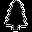

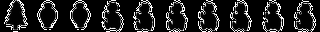

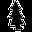

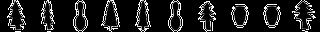

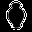

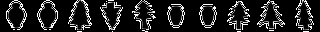

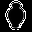

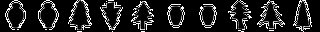

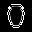

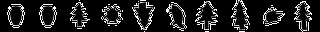

Final Results


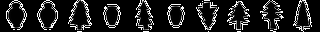

Precision: 0.60, Recall: 0.38

Query: shoe


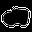

Original Results


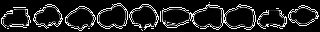

Precision: 0.30, Recall: 0.17
AQE Results with first 5 results
 


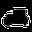

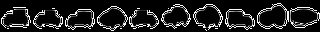

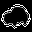

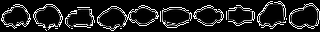

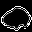

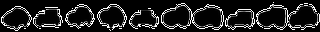

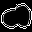

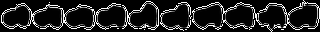

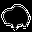

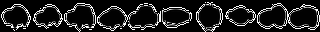

Final Results


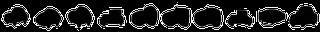

Precision: 0.30, Recall: 0.17

Query: device8


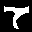

Original Results


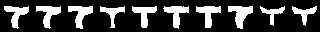

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


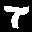

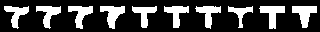

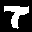

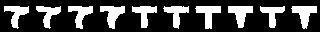

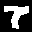

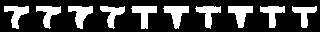

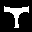

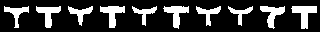

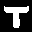

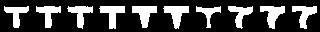

Final Results


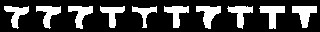

Precision: 1.00, Recall: 0.62

Query: stef


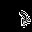

Original Results


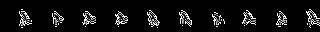

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


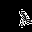

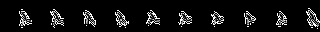

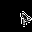

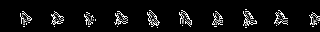

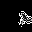

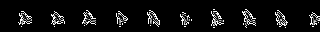

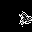

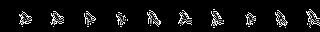

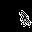

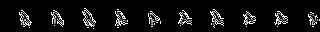

Final Results


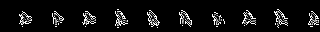

Precision: 1.00, Recall: 0.56

Query: device3


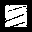

Original Results


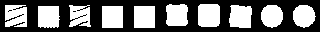

Precision: 0.80, Recall: 0.57
AQE Results with first 5 results
 


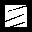

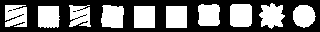

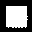

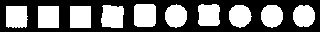

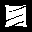

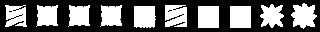

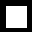

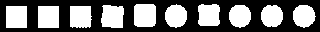

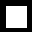

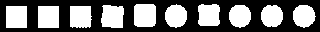

Final Results


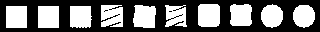

Precision: 0.80, Recall: 0.57

Query: Heart


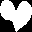

Original Results


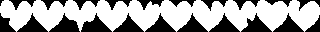

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


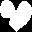

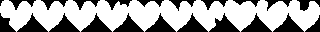

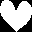

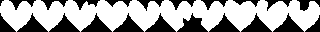

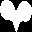

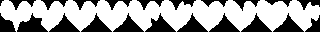

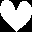

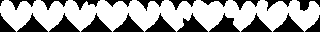

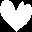

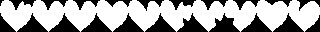

Final Results


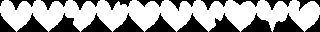

Precision: 1.00, Recall: 0.56

Query: fountain


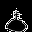

Original Results


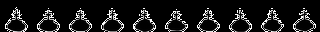

Precision: 1.00, Recall: 0.59
AQE Results with first 5 results
 


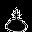

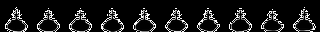

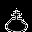

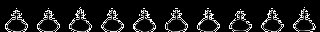

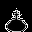

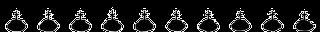

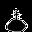

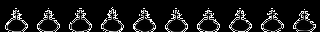

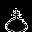

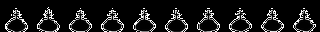

Final Results


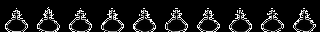

Precision: 1.00, Recall: 0.59

Query: apple


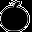

Original Results


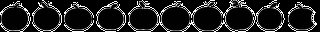

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


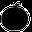

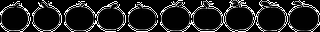

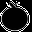

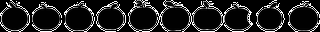

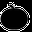

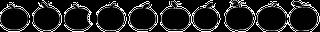

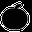

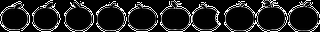

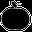

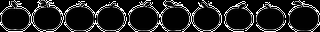

Final Results


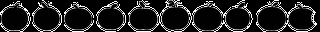

Precision: 1.00, Recall: 0.56

Query: watch


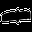

Original Results


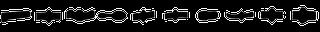

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


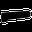

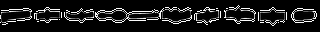

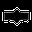

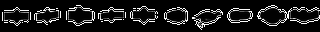

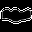

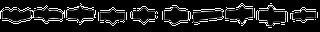

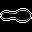

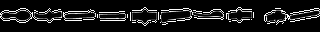

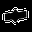

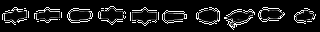

Final Results


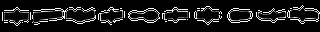

Precision: 0.70, Recall: 0.50

Query: crown


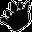

Original Results


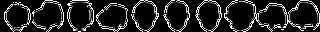

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


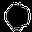

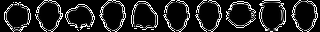

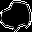

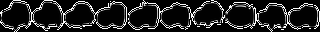

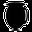

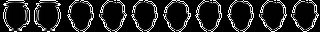

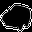

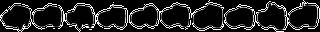

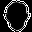

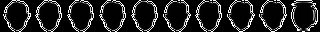

Final Results


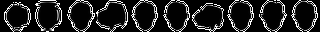

Precision: 0.00, Recall: 0.00

Query: butterfly


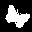

Original Results


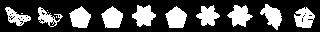

Precision: 0.20, Recall: 0.14
AQE Results with first 5 results
 


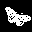

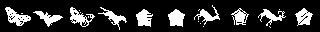

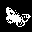

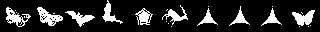

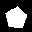

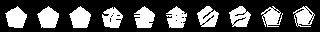

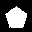

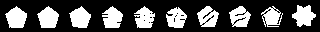

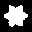

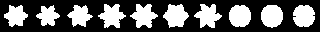

Final Results


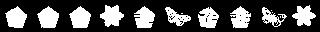

Precision: 0.20, Recall: 0.14

Query: car


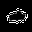

Original Results


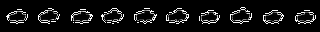

Precision: 1.00, Recall: 0.59
AQE Results with first 5 results
 


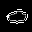

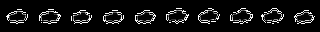

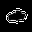

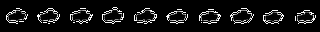

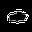

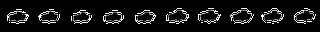

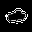

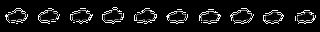

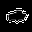

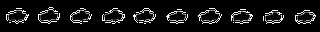

Final Results


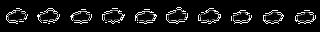

Precision: 1.00, Recall: 0.59

Query: frog


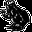

Original Results


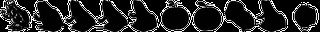

Precision: 0.60, Recall: 0.35
AQE Results with first 5 results
 


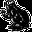

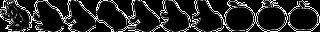

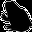

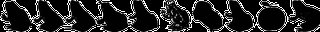

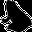

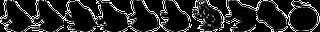

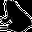

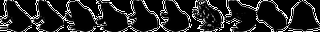

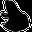

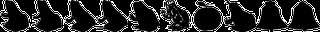

Final Results


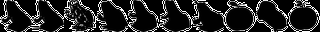

Precision: 0.70, Recall: 0.41

Query: chopper


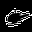

Original Results


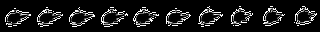

Precision: 1.00, Recall: 0.91
AQE Results with first 5 results
 


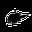

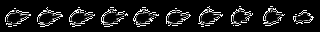

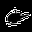

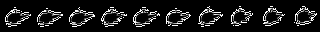

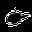

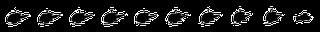

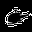

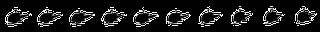

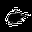

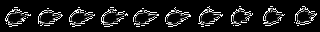

Final Results


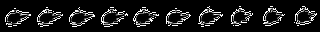

Precision: 1.00, Recall: 0.91

Query: watch


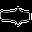

Original Results


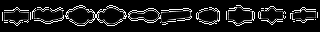

Precision: 0.50, Recall: 0.36
AQE Results with first 5 results
 


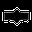

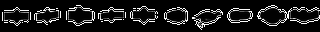

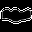

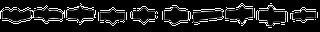

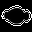

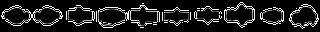

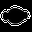

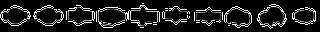

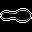

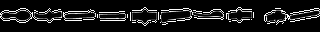

Final Results


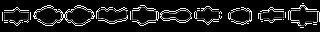

Precision: 0.60, Recall: 0.43

Query: jar


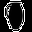

Original Results


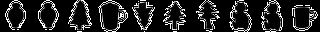

Precision: 0.20, Recall: 0.12
AQE Results with first 5 results
 


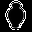

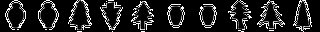

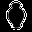

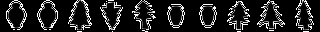

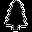

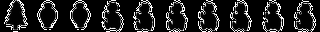

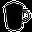

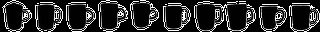

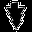

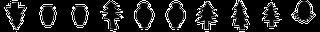

Final Results


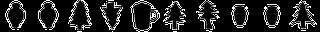

Precision: 0.40, Recall: 0.25

Query: watch


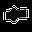

Original Results


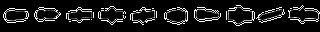

Precision: 0.50, Recall: 0.36
AQE Results with first 5 results
 


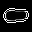

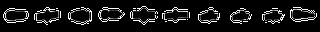

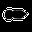

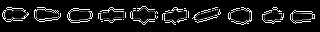

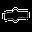

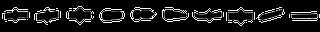

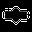

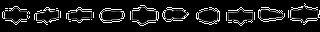

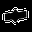

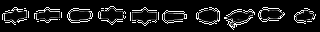

Final Results


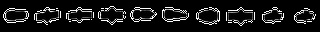

Precision: 0.40, Recall: 0.29

Query: guitar


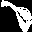

Original Results


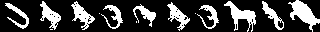

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


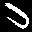

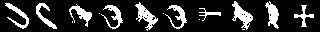

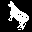

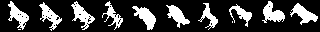

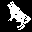

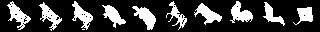

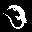

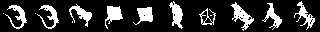

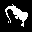

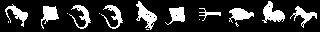

Final Results


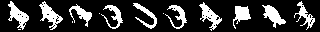

Precision: 0.00, Recall: 0.00

Query: device3


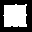

Original Results


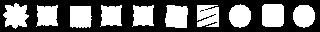

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


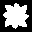

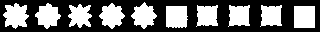

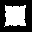

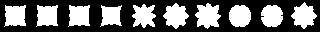

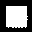

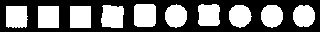

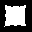

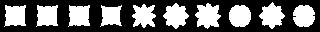

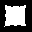

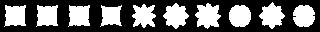

Final Results


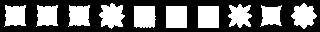

Precision: 0.70, Recall: 0.50

Query: apple


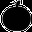

Original Results


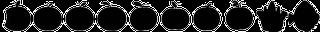

Precision: 0.80, Recall: 0.44
AQE Results with first 5 results
 


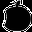

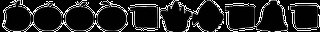

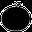

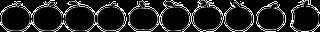

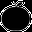

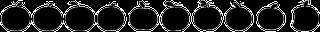

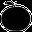

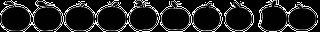

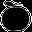

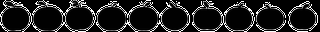

Final Results


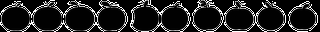

Precision: 1.00, Recall: 0.56

Query: chopper


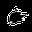

Original Results


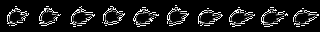

Precision: 1.00, Recall: 0.91
AQE Results with first 5 results
 


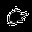

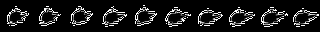

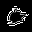

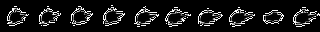

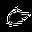

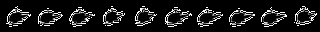

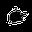

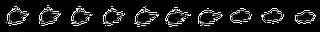

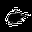

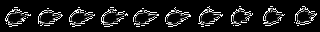

Final Results


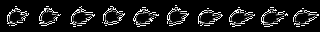

Precision: 1.00, Recall: 0.91

Query: device6


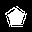

Original Results


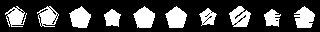

Precision: 1.00, Recall: 0.56
AQE Results with first 5 results
 


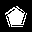

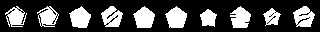

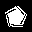

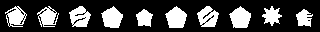

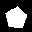

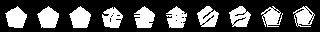

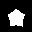

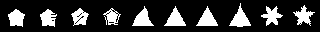

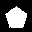

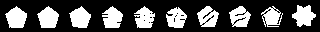

Final Results


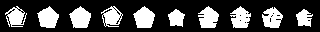

Precision: 1.00, Recall: 0.56

Query: bottle


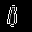

Original Results


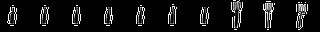

Precision: 0.70, Recall: 0.50
AQE Results with first 5 results
 


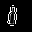

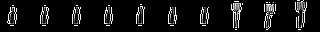

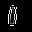

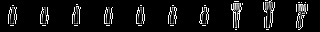

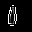

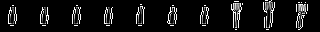

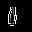

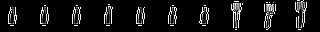

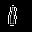

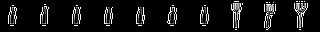

Final Results


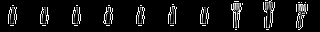

Precision: 0.70, Recall: 0.50

Query: Misk


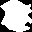

Original Results


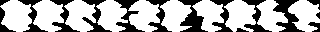

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


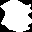

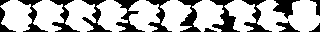

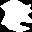

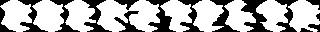

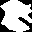

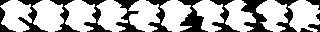

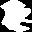

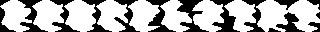

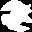

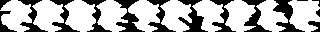

Final Results


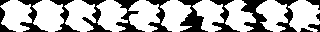

Precision: 1.00, Recall: 0.67

Query: fish


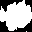

Original Results


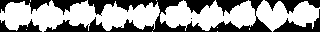

Precision: 0.90, Recall: 0.60
AQE Results with first 5 results
 


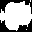

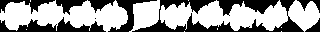

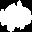

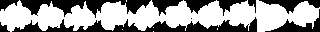

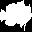

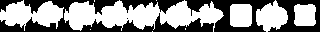

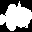

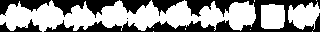

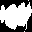

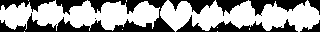

Final Results


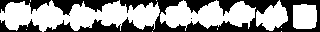

Precision: 0.90, Recall: 0.60

Query: fork


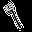

Original Results


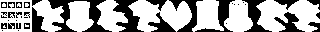

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


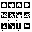

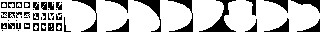

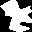

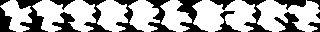

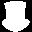

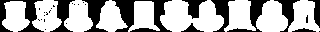

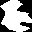

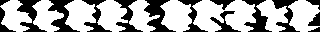

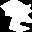

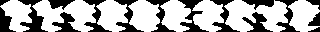

Final Results


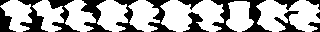

Precision: 0.00, Recall: 0.00

Query: beetle


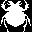

Original Results


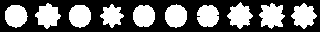

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


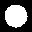

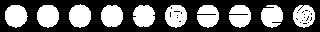

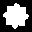

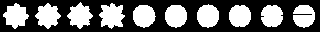

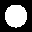

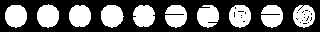

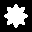

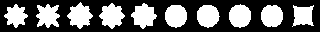

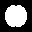

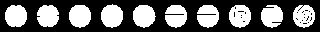

Final Results


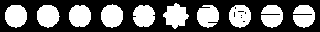

Precision: 0.00, Recall: 0.00

Query: chopper


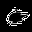

Original Results


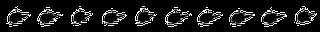

Precision: 1.00, Recall: 0.91
AQE Results with first 5 results
 


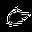

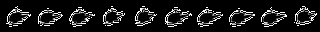

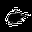

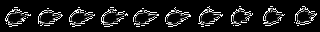

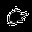

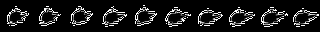

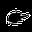

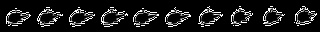

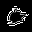

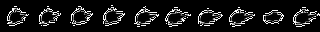

Final Results


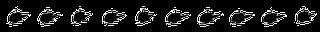

Precision: 1.00, Recall: 0.91

Query: truck


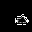

Original Results


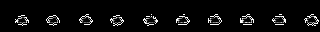

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


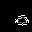

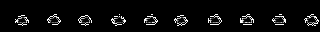

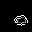

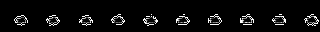

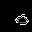

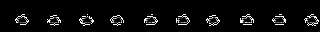

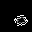

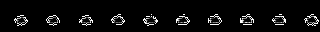

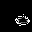

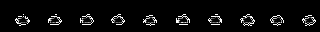

Final Results


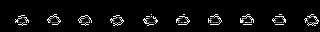

Precision: 1.00, Recall: 0.67

Query: pencil


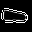

Original Results


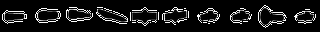

Precision: 0.40, Recall: 0.25
AQE Results with first 5 results
 


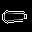

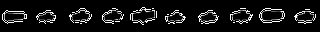

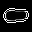

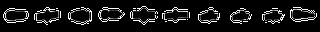

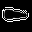

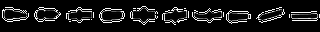

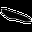

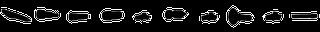

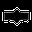

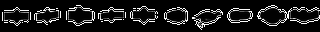

Final Results


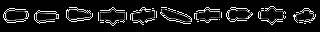

Precision: 0.50, Recall: 0.31

Query: key


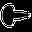

Original Results


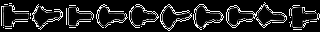

Precision: 1.00, Recall: 0.71
AQE Results with first 5 results
 


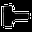

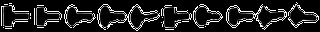

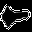

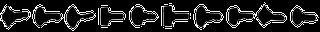

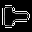

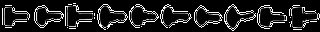

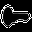

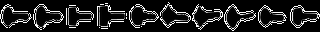

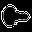

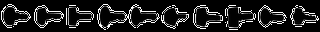

Final Results


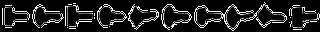

Precision: 1.00, Recall: 0.71

Query: spring


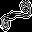

Original Results


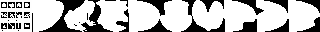

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


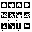

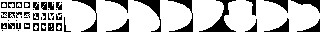

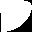

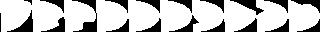

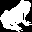

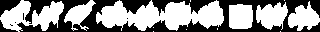

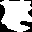

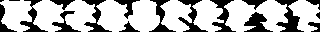

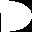

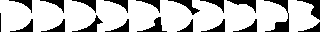

Final Results


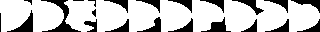

Precision: 0.00, Recall: 0.00

Query: personal_car


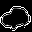

Original Results


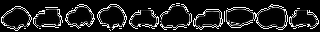

Precision: 0.40, Recall: 0.24
AQE Results with first 5 results
 


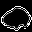

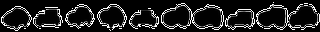

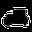

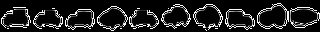

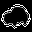

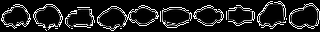

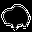

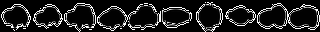

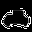

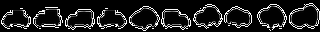

Final Results


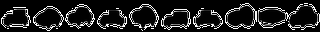

Precision: 0.40, Recall: 0.24

Query: Comma


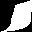

Original Results


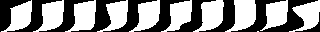

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


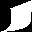

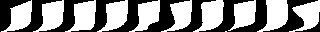

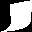

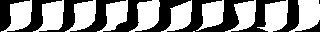

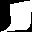

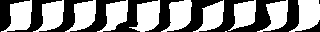

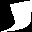

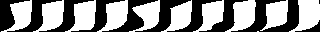

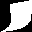

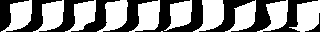

Final Results


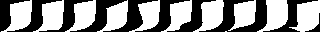

Precision: 1.00, Recall: 0.67

Query: bird


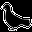

Original Results


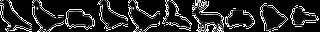

Precision: 0.40, Recall: 0.24
AQE Results with first 5 results
 


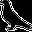

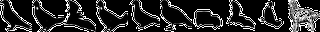

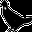

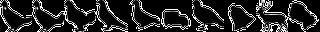

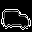

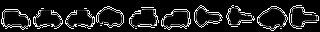

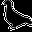

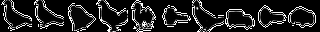

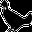

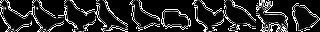

Final Results


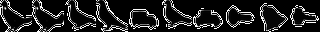

Precision: 0.50, Recall: 0.29

Query: fork


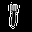

Original Results


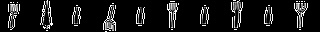

Precision: 0.50, Recall: 0.38
AQE Results with first 5 results
 


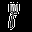

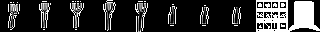

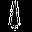

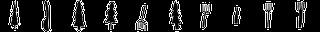

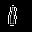

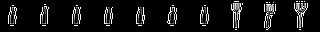

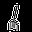

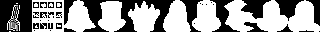

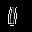

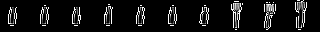

Final Results


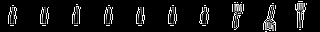

Precision: 0.30, Recall: 0.23

Query: fly


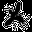

Original Results


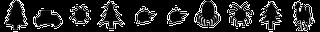

Precision: 0.00, Recall: 0.00
AQE Results with first 5 results
 


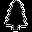

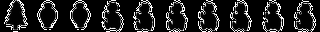

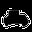

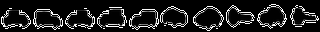

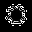

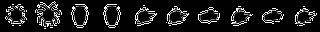

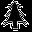

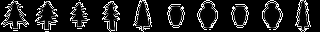

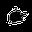

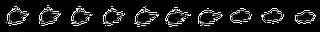

Final Results


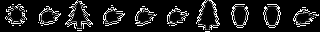

Precision: 0.00, Recall: 0.00

Query: device9


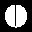

Original Results


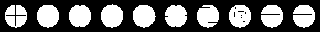

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


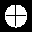

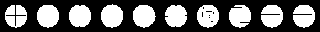

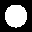

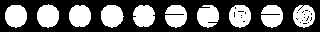

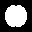

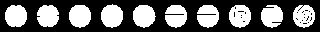

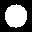

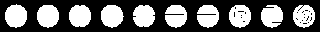

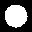

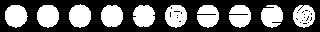

Final Results


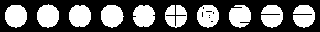

Precision: 1.00, Recall: 0.67

Query: watch


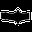

Original Results


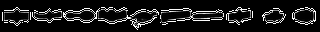

Precision: 0.40, Recall: 0.29
AQE Results with first 5 results
 


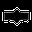

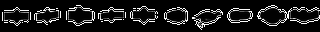

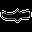

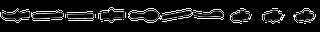

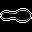

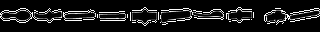

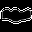

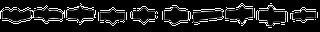

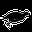

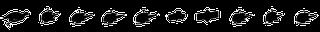

Final Results


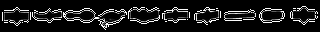

Precision: 0.60, Recall: 0.43

Query: cattle


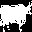

Original Results


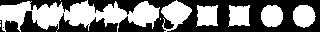

Precision: 0.10, Recall: 0.08
AQE Results with first 5 results
 


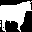

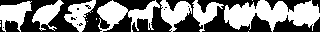

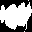

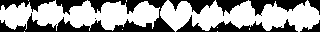

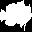

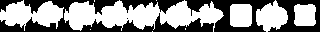

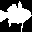

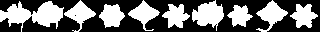

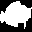

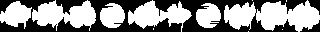

Final Results


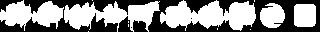

Precision: 0.10, Recall: 0.08

Query: bell


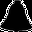

Original Results


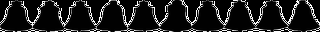

Precision: 1.00, Recall: 0.67
AQE Results with first 5 results
 


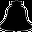

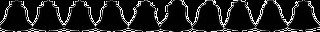

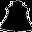

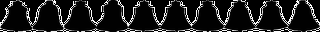

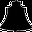

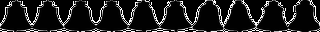

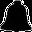

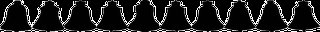

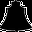

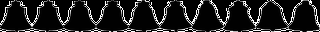

Final Results


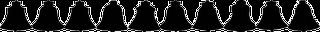

Precision: 1.00, Recall: 0.67

Query: cellular_phone


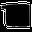

Original Results


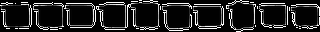

Precision: 1.00, Recall: 0.77
AQE Results with first 5 results
 


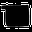

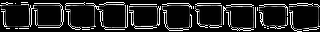

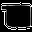

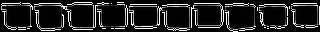

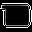

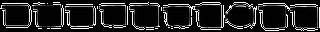

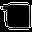

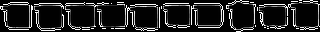

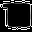

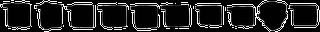

Final Results


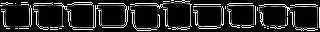

Precision: 1.00, Recall: 0.77

Query: jar


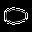

Original Results


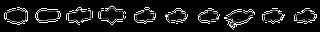

Precision: 0.10, Recall: 0.06
AQE Results with first 5 results
 


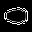

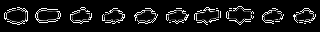

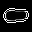

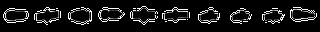

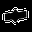

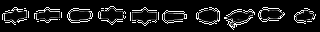

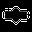

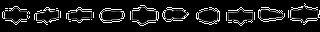

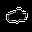

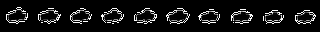

Final Results


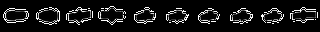

Precision: 0.10, Recall: 0.06

Query: horse


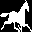

Original Results


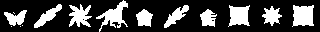

Precision: 0.10, Recall: 0.07
AQE Results with first 5 results
 


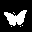

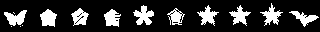

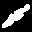

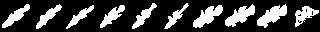

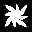

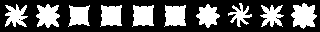

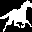

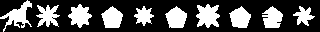

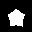

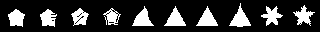

Final Results


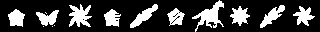

Precision: 0.10, Recall: 0.07

Query: device7


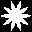

Original Results


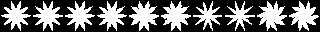

Precision: 1.00, Recall: 0.62
AQE Results with first 5 results
 


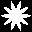

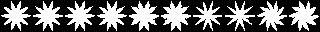

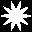

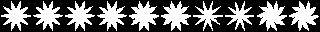

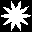

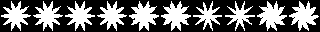

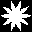

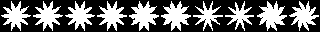

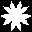

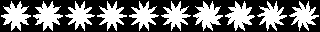

Final Results


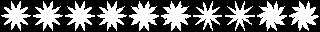

Precision: 1.00, Recall: 0.62


In [20]:
avg_precision, avg_recall = aqe_all_images(k=10, m=5, threshold=0, start=0, end=len(X_test),display=True, display_AQE=True)

In [21]:
print(avg_precision, avg_recall)

0.6245551601423488 0.42238148300778444


In [22]:
calculate_range_of_k(1,20,5,0.5,True)

Threshold: 0.5 m: 5

k = 1
Precison = 1.00
Recall = 0.07

k = 2
Precison = 0.96
Recall = 0.13

k = 3
Precison = 0.97
Recall = 0.20

k = 4
Precison = 0.92
Recall = 0.25

k = 5
Precison = 0.92
Recall = 0.31

k = 6
Precison = 0.90
Recall = 0.37

k = 7
Precison = 0.94
Recall = 0.44

k = 8
Precison = 0.90
Recall = 0.49

k = 9
Precison = 0.91
Recall = 0.55

k = 10
Precison = 0.87
Recall = 0.59

k = 11
Precison = 0.87
Recall = 0.65

k = 12
Precison = 0.85
Recall = 0.68

k = 13
Precison = 0.86
Recall = 0.75

k = 14
Precison = 0.82
Recall = 0.77

k = 15
Precison = 0.81
Recall = 0.82

k = 16
Precison = 0.77
Recall = 0.82

k = 17
Precison = 0.76
Recall = 0.86

k = 18
Precison = 0.73
Recall = 0.87

k = 19
Precison = 0.71
Recall = 0.90


([1.0,
  0.9617117117117117,
  0.9684044233807266,
  0.9181818181818182,
  0.9223300970873787,
  0.9014423076923077,
  0.9378881987577641,
  0.9029255319148937,
  0.9051186017478152,
  0.873076923076923,
  0.8738833420914346,
  0.8462643678160919,
  0.8564429201371876,
  0.8227848101265823,
  0.8147126436781609,
  0.771832191780822,
  0.7598770851624232,
  0.7254901960784315,
  0.7082469954413594],
 [0.06846130303865881,
  0.1313408145838486,
  0.1983097346043585,
  0.25047284752727333,
  0.3132974902258996,
  0.3669608934980898,
  0.44353737885968,
  0.48746238802806224,
  0.5489999092040175,
  0.5880091052634261,
  0.6468213717081807,
  0.6821475518903991,
  0.7472890958162892,
  0.7720745853755221,
  0.8177594145590836,
  0.8248441005465265,
  0.8621265497475585,
  0.870199500128304,
  0.8985455144047693])

In [23]:
dill.dump_session("Pixel_Value_With_AQE_Baseline.db")